In [172]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, date
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import math

---
# Functions used throughout notebook

### Function based on methods in Yang et al. (1995)
Yang, S., Logan, J., & Coffey, D. L. (1995). Agricultural Mathematical formulae for calculating the base temperature for growing degree days. Agricultural and Forest Meteorologyand Forest Meteorology, 74, 61–74.

In [173]:
# Function estimates optimal base temperature given input cotton growth dataset using the four algorigthms
# described in Yang et al. (1995). These methods are Standard Deviation in GDDs, Regression Coefficient,
# Coefficient of Variation, and Standard Deviation in Days
#
# Function returns a dataframe organized by stage, cultivar, and optimal base temperatures for each method.
def base_est_all_methods(input_df):

    # Create list to store all output
    base_temp_ests = []

    # Iterate through all cultivars (there are 3)
    cultivars = input_df['cultivar'].unique().tolist()
    for v in range(len(cultivars)):
        
        # Then iterate through all stages
        stages = input_df[(input_df['cultivar']==cultivars[v])][
            'stage'].unique().tolist()
        for s in range(len(stages)):
            
            # Pull out data for just this stage and cultivar
            data_train = input_df[(input_df['cultivar']==cultivars[v]) &
                                  (input_df['stage']==stages[s])].dropna().copy()

            n_sites = data_train.shape[0]

            #--------------------------
            ## STD DEV IN GDD METHOD
            # Numerator
            data_train['Ti_di'] = data_train['mean_temp']*data_train['ndays']
            data_train['disq_Ti'] = data_train['ndays']*data_train['ndays']*data_train['mean_temp']

            sum_Ti_di = (sum(data_train['Ti_di']))
            sum_di = (sum(data_train['ndays']))
            sum_disq_Ti = (sum(data_train['disq_Ti']))
            base_temp_num_stdgdd = (sum_Ti_di*sum_di) - (n_sites*sum_disq_Ti)

            # Denominator     
            data_train['disq'] = data_train['ndays']*data_train['ndays']
            sum_di_sq = sum_di * sum_di
            sum_disq = sum(data_train['disq'])
            base_temp_denom_stdgdd = (sum_di_sq) - (n_sites*sum_disq)
            base_temp_stdgdd = base_temp_num_stdgdd / base_temp_denom_stdgdd

            #-------------------------
            ## REG COEFF METHOD
            # Numerator
            data_train['di_Tisq'] = data_train['mean_temp']*data_train['mean_temp']*data_train['ndays']

            # Get values for equation
            sum_Ti = sum(data_train['mean_temp'])
            sum_Ti_di = (sum(data_train['Ti_di']))
            sum_di_Tisq = (sum(data_train['di_Tisq']))
            base_temp_num_regcoeff = (sum_Ti*sum_Ti_di) - (n_sites*sum_di_Tisq)
            base_temp_denom_regcoeff = (sum_di*sum_Ti) - (n_sites*sum_Ti_di)
            base_temp_regcoeff = base_temp_num_regcoeff / base_temp_denom_regcoeff

            #------------------------
            # COEFF VAR GDD METHOD
            # Numerator
            data_train['Ti_disq'] = data_train['mean_temp']*data_train['ndays']*data_train['ndays']
            data_train['Tisq_disq'] = data_train['mean_temp']*data_train['mean_temp'] * data_train['ndays']*data_train['ndays']

            # Numerator - get values for equation
            sum_Ti_disq = (sum(data_train['Ti_disq']))
            sum_Tisq_disq = sum(data_train['Tisq_disq'])
            base_temp_num_cv = (sum_Ti_disq*sum_Ti_di) - (sum_di*sum_Tisq_disq)

            # Denominator
            base_temp_denom_cv = (sum_disq*sum_Ti_di) - (sum_di*sum_Ti_disq)
            base_temp_cv = base_temp_num_cv / base_temp_denom_cv

            #--------------------------
            ## STD DEV DAYS METHOD
            mean_temp_all = data_train['mean_temp'].mean()
            data_train['mean_temp_all_plantings'] = data_train['mean_temp'].mean()
            data_train['t_i'] = data_train['mean_temp_all_plantings']-data_train['mean_temp']
            data_train['t_i_d_i'] = data_train['t_i'] * data_train['ndays']
            data_train['tisq_disq'] = data_train['t_i']*data_train['t_i'] * data_train['ndays']*data_train['ndays']
            data_train['disq_ti'] = data_train['ndays']*data_train['ndays']*data_train['t_i']

            # Numerator
            sum_tidi_sq = (sum(data_train['t_i_d_i'])) * (sum(data_train['t_i_d_i']))
            n_sum_tisq_disq = n_sites * sum(data_train['tisq_disq'])

            # Denominator
            n_sum_disq_ti = n_sites * sum(data_train['disq_ti'])
            n_sum_tidi = n_sites * sum(data_train['t_i_d_i'])
            sum_di = sum(data_train['ndays'])

            base_temp_num_stddays = sum_tidi_sq - n_sum_tisq_disq
            base_temp_denom_stddays = n_sum_disq_ti - (n_sum_tidi * sum_di)
            base_temp_stddays = mean_temp_all - (base_temp_num_stddays / base_temp_denom_stddays)

            # OUTPUT TO LIST
            base_temp_ests.append({'cultivar':cultivars[v],
                                   'stage':stages[s],
                                   'base_temp_stdgdd':base_temp_stdgdd,
                                   'base_temp_regcoeff':base_temp_regcoeff,
                                   'base_temp_coeffvargdd':base_temp_cv,
                                   'base_temp_stddays':base_temp_stddays})

    est_base_temp_df = pd.DataFrame(base_temp_ests)
    return(est_base_temp_df)

### Function below determines the number of days to reach GDDthreshold. Computes GDDs using input base temperature and daily Tmean array

In [174]:
# Function to compute day on which reach given growth stage.
# Compuate daily GDD given input Tmean temperature numpy array and base temperature (scalar)
# Accumulates these and determines the date on which growth stage is met by comparing to GDDthresh
# Outputs S - the number of days to reach  growth stage
def getDaysToStage(Tmean,Tbase,GDDthresh):
    
    # Number of days to get to given growth stage
    S = len(Tmean)
    
    # Cumulative GDD variable (will be NGDD)
    NGDD = 0
    
    # Iterate through each day, add to  NGDD
    for d in range(S):
        curr_GDD = max(Tmean[d],Tbase) - Tbase
        NGDD = NGDD + curr_GDD
        
        
        #print(d,Tbase,curr_GDD,NGDD,GDDthresh)
        
        if(NGDD > GDDthresh):
            break;
            #return(d)
    
    # If get here, means we never returned a number, in which case, return nan
    #return(np.nan)
    #print("-------------------")
    if(NGDD > GDDthresh):
        return(d)
    else:
        return(np.nan)

### Function uses input optimal Tbase dataframe and associated GDD requirements for each growth stage to calculate the predicted date at which each growth stage would occur using input test data, and compares this with observed date.

In [175]:
# Block does same as block above, but this time making more dynamic -- so can test for 
# different Tbases

## Things we need:
# tbase_best_df = optimal Tbase dataframe. Expects columns: Cultivar	Stage	Tbase	GDD_Threshold	stage_num
# test_data = growth_pd[growth_pd['test_train']==0].copy()
# wx_data = wxdf
# run_type = 'from_plant' for runs that have accumulations/tbase to each stage that accrue from plant date, or
#          = 'each' for runs that start from previous stage
def getPredObs_DaysToStage(tbase_best_df,test_data,wx_data,run_type):

    test_data.set_index(['loc_id','cultivar','plot'],inplace=True)

    # Output 
    vald_arr = []

    # Iterate through each location-cultivar-plot
    for i in set(test_data.index):
        curr_growth = test_data.loc[i].copy()

        # Current loc_id
        curr_loc = list(i)[0]

        # Current cultivar
        curr_cult = list(i)[1]

        # Current plot:
        curr_plot = list(i)[2]


        # Get weather data associated with this location (will be used for all plots at this location)
        curr_wx = wx_data[wx_data['loc_id']==curr_loc]

        # Get plant date
        plant_day_of_year = curr_growth[curr_growth['stage_num']==1]['day_of_year_stage'].values[0] - \
                            curr_growth[curr_growth['stage_num']==1]['elapse_days'].values[0]

        # Iterate through stages (use stage_num, since is numeric); (loop ends at 7 -- means will evaluate 1-6)
        for s in range(1,7):

            # Current tbase
            curr_tbase = tbase_best_df[(tbase_best_df['Cultivar']==curr_cult) &
                                                (tbase_best_df['stage_num']==s)]['Tbase'].values[0]

            # Number of accumulated GDD to reach stage
            curr_ngdd = tbase_best_df[(tbase_best_df['Cultivar']==curr_cult) &
                                              (tbase_best_df['stage_num']==s)]['GDD_Threshold'].values[0]

            # Get date of current stage, if exists
            stage_day = curr_growth[curr_growth['stage_num']==s]['day_of_year_stage'].values
            if len(stage_day) > 0:
                stage_day_of_year = stage_day[0]
            else:
                stage_day_of_year = np.nan

                
            # If doing from Plant Date:
            if run_type=='from_plant':
                
                # Create df with just growing season data, compute GDD using tbase, then cumusm and compare to gdd reqs
                wx_plot = curr_wx[curr_wx['date']>=plant_day_of_year].copy()


                # Call function to calculate the number of days to rech stage (is based on Tmean array)
                pred_ndays_stage = getDaysToStage(np.array(wx_plot['tmean_F']),curr_tbase,curr_ngdd)
                
                # Then compute the day of year that this is by adding the plant day of year:
                pred_stage_day_of_year = plant_day_of_year + pred_ndays_stage

                vald_arr.append({'cultivar':curr_cult,'stage_num':s,'loc_id':curr_loc,'plot':curr_plot,
                                'Pred_Day_Yr':pred_stage_day_of_year,'Obs_Day_Yr':stage_day_of_year,
                                'Obs-Pred':(stage_day_of_year - pred_stage_day_of_year)})
                
            # Else, doing for each growth stage
            else:
                # Get the day of year for the previous growth stage:
                prev_day_year = np.nan
                if s==1:
                    prev_day_year = plant_day_of_year-1
                else:
                    prev_arr = curr_growth[curr_growth['stage_num']==s-1]['day_of_year_stage'].values
                    if len(prev_arr)>0:
                        prev_day_year = prev_arr[0]
                
                # If we have both this stage's date AND the last stage's date, we can compute
                if (math.isnan(prev_day_year)==False) & (math.isnan(stage_day_of_year)==False):
                    # 
                    wx_plot = curr_wx[(curr_wx['date']>prev_day_year)].copy()

                    # Call function to calculate the number of days to reach stage (is based on Tmean array)
                    pred_ndays_stage = getDaysToStage(np.array(wx_plot['tmean_F']),curr_tbase,curr_ngdd)
                    
                    # Observed Days this stage:
                    obs_ndays_stage = curr_growth[curr_growth['stage_num']==s]['days_this_stage'].values[0]
                    
                    # Then compute the day of year that this is by adding the plant day of year:
                    pred_stage_day_of_year = plant_day_of_year + pred_ndays_stage
                    
                    vald_arr.append({'cultivar':curr_cult,'stage_num':s,'loc_id':curr_loc,'plot':curr_plot,
                                    'Pred_Days':pred_ndays_stage,'Obs_Days':obs_ndays_stage,
                                    'Obs-Pred':(obs_ndays_stage - pred_ndays_stage)})

                else:
                    vald_arr.append({'cultivar':curr_cult,'stage_num':s,'loc_id':curr_loc,'plot':curr_plot,
                                    'Pred_Days':np.nan,'Obs_Days':np.nan,
                                    'Obs-Pred':np.nan})                    
            
    return(pd.DataFrame(vald_arr))

### Function below outputs accumulated GDD, given input base temperature and daily Tmean array, over the whole array

In [176]:
# Function to compute NGDD (total GDD) given input Tmean temperature numpy array and base temperature (scalar)
def getNGDD(Tmean,Tbase):
    
    # Number of days to get to given growth stage
    S = len(Tmean)
    
    # Cumulative GDD variable (will be NGDD)
    NGDD = 0
    
    # Iterate through each day, add to  NGDD
    for d in range(S):
        curr_GDD = max(Tmean[d],Tbase) - Tbase
        NGDD = NGDD + curr_GDD
    
    # Adding here: if NGDD = 0, means we never accumulated any GDD, so set this back to nan
    if NGDD == 0:
        NGDD = np.nan
    return(S,NGDD)

---
# Read in Meteorological Data

In [177]:
## Read in Cotton location metadata
# This is from a .csv file that I generated -- based on the tab "location_data" in Maturity_2018_2019.xlsx
# Added a row: LA_2019 (loc_9) because there is a LA_2019 data tab/row in the the spreadsheet. Assuming that
#              the location information for LA_2019 is identical to that of LA_2018 (loc_8)
meta_pd = pd.read_csv(open('CottonDataFiles/stations.csv','rb'), 
                        dtype={'Year': float, 'State': str, 
                               'City': str, 'Latitude': float, 
                               'Longitude': float, 'State2':str,'loc_year':str,'loc_id':str})  

In [178]:
# Read in gridMET data that we've already obtained
gridmet_in = pd.read_csv('MetDataFiles/GridMET_forAnalysis_2018_2019.csv')
df_gridmet = gridmet_in.pivot(index=['loc_id','latitude','longitude','year','date'],
                    columns=['VarName'])
df_gridmet.reset_index(inplace=True)

In [179]:
# Convert gridMET Tmax and Tmin from Kelvin to Fahrenheit (precip is is scaled to units mm)
# These come from NetCDF files
scale_factor = 0.1
offset_min = 210.0
offset_max = 220.0

df_gridmet['tmmn_C'] = ((df_gridmet['Value']['tmmn'] * scale_factor + offset_min))- 273.15
df_gridmet['tmmx_C'] = ((df_gridmet['Value']['tmmx'] * scale_factor + offset_max))- 273.15
df_gridmet['tmmn_F'] = df_gridmet['tmmn_C'] * (9/5) + 32
df_gridmet['tmmx_F'] = df_gridmet['tmmx_C'] * (9/5) + 32
df_gridmet['tmean_F'] = (df_gridmet['tmmx_F'] + df_gridmet['tmmn_F'])/2

df_gridmet['pr_scaled'] = df_gridmet['Value']['pr'] * scale_factor

# Organize column headings (is currently a multiindex, flattening this)
df_gridmet.columns = [''.join(col) for col in df_gridmet.columns.values]

# Drop the unscaled, raw data from the dataframe(but retain the values in deg C, deg F, and mm)
df_gridmet.drop(columns=['Valuepr','Valuesrad','Valuetmmn','Valuetmmx'],inplace=True)

In [180]:
# PRISM data were obtained separately using PRISM's data explorer 
# This is a GUI interfrace where users can enter in a lat/long onto a web interface and download time series
# Since there were only 13 locations for this, and since there's not THREDDS server that provides PRISM from
# https://prism.oregonstate.edu/, this was the fastest route
# Here we're just reading in PRISM data that we've already obtained and storedin a csv file
prism_frames = []
for i in range(len(meta_pd.loc_id.unique().tolist())):
    curr_df = pd.read_csv("MetDataFiles/PRISM_2018_2019/PRISM_"+meta_pd.loc_id.unique().tolist()[i]+".csv",
                          skiprows=10)
    curr_df['loc_id'] = meta_pd.loc_id.unique().tolist()[i]
    prism_frames.append(curr_df)
df_prism = pd.concat(prism_frames)
df_prism.rename(columns={'ppt (inches)':'pr','tmax (degrees F)':'tmmx_F','tmin (degrees F)':'tmmn_F',
                        'tmean (degrees F)':'tmean_F','Date':'Full_date'},inplace=True)
df_prism['date'] = df_prism['Full_date'].apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d').timetuple().tm_yday-1)
df_prism['year'] = df_prism['Full_date'].apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d').timetuple().tm_year)


---
# Read in  Growth Data
Then compute number of Days Between Each Growth Stage

In [181]:
# Actual Cotton Growth Stage Data
growth_pd = pd.read_excel(open('CottonDataFiles/Maturity_2018_2019.xlsx', 
                               'rb'), sheet_name='combined_18_19',
                          header=0, usecols = "A,B,D,E,F,G,H,I,J",
                          dtype={'location': str, 'year':int, 'plot': int, 
                                 'cultivar': str, 'loc_year':str, 'loc_var': str, 
                                 'growth stage': str, 'date': str,
                                 'plant_date':str})
growth_pd.dropna(inplace=True)

In [182]:
# Fixing Cultivar DP 1851 B2XF to DP 1851 B3XF (was a file typo -- easier to fix here!)
growth_pd.loc[growth_pd['cultivar']=='DP 1851 B2XF','cultivar'] = 'DP 1851 B3XF'

In [183]:
# Do some organization of data and add columns to indicate day of year and the day of each stage

# Array of loc_id's
loc_id_arr = meta_pd['loc_id'].tolist()

# Add loc_id column, matching from meta_pd dataframe, to growth_pd dataframe
growth_pd['loc_id'] = ''
for i in range(len(loc_id_arr)):
    loc_yr_id = meta_pd[meta_pd['loc_id'] == loc_id_arr[i]]['loc_year'].values[0]
    growth_pd.loc[(growth_pd['loc_year']==loc_yr_id) ,'loc_id'] = loc_id_arr[i]
    
# Change data type of "date" (date of each stage) and "plant" (planting date) columns to datetime
growth_pd['date'] = pd.to_datetime(growth_pd['date'], errors='coerce')
growth_pd['plant'] = pd.to_datetime(growth_pd['plant'], errors='coerce')

# Sort everything by date
growth_pd.sort_values(by=['loc_id','plot','date'],inplace=True)

# Compute the number of elapsed days from plant date to a given growth stage
growth_pd['elapse_days'] = (growth_pd['date']-growth_pd['plant']).dt.days

# Compute the day of year for given growth stage (to make it easier to grab from weather dataframe)
growth_pd['jan1'] = pd.to_datetime(growth_pd['year'].astype(str)+'-1-1')
growth_pd['day_of_year_stage'] = (growth_pd['date'] - growth_pd['jan1']).dt.days
growth_pd.drop(columns='jan1',inplace=True)

In [184]:
# Create a numeric column for stages, called stage_num. This will make it easier for sorting things later
all_stages_order = ['emerge','square','flower','cutout','cracked','60open']
stage_dict = {'emerge':1,'square':2,'flower':3,'cutout':4,'cracked':5,'60open':6}
growth_pd['stage_num'] = growth_pd['growth stage'].map(stage_dict)

In [185]:
# Set index in dataframe to a combination of loc_id, cultivar, and plot (will make subsequent computations cleaner)
growth_pd.set_index(['loc_id','cultivar','plot'],inplace=True)
growth_pd.sort_index(inplace=True)

In [186]:
# Compute difference (just number of days to get from previous stage to current stage)
growth_pd['diff_days'] = growth_pd['elapse_days']
growth_pd['days_this_stage'] = pd.DataFrame(growth_pd['diff_days'].diff()).reset_index().diff_days.values

# All values for 'emerge' will be NaN, so update with the correct val = elapsed days from plant date to emergence
growth_pd.reset_index(inplace=True)
growth_pd.loc[growth_pd['growth stage']=='emerge','days_this_stage'] = growth_pd['elapse_days']

# Drop the temporary column 'diff_days'
growth_pd.drop(columns=['diff_days'],inplace=True)

In [187]:
# There are some duplicate entries for certain stages -- drop these, keeping the first:
growth_pd.drop_duplicates(subset=['loc_id','cultivar','plot','growth stage'],keep='first',inplace=True)

# Set the temperature dataset we'll use for all analyses
Using PRISM (assign wxdf to appropriate dataframe)


In [188]:
#wxdf = df_gridmet.copy() # gridMET
wxdf = df_prism.copy() # PRISM

### Separate TRAINING and TEST Sets Based on Year

In [189]:
# Training set = 1; Test set = 0
growth_pd['test_train'] = 0
growth_pd.loc[growth_pd['year']==2018,'test_train'] = 1


---
---
---
# Part 1. Use Yang et al. (1995) methods to estimate base temperature

### First: iterate through data and compute mean temperature during each growth stage

In [190]:
wxdf_copy = wxdf.copy().reset_index()

In [191]:
# Next parse Training cotton growth data and weather data to get the mean temperature for each growth stage
# Do this for the full season (i.e., from planting date to each stage) as well as for each stage
# individually (i.e., from the day after reaching previous stage to current stage)
train_data = growth_pd[(growth_pd['test_train']==1)].copy()
train_data.set_index(['loc_id','cultivar','plot'],inplace=True)

arr_tmeans_each_stage = []
arr_tmeans_since_plant = []
# Loop through each multi-index (location-cultivar-plot)
for i in set(train_data.index):
        
    copy_train = pd.DataFrame(train_data.loc[i].copy())
    
    # Get start and end dates corresponding to this location's (loc_id-cultivar-plot) plant date and harvest (60open)
    plant_day = copy_train[copy_train['growth stage']=='emerge']['day_of_year_stage'].values[0] - \
                copy_train[copy_train['growth stage']=='emerge']['elapse_days'].values[0]
    
    # Iterate through each stage (stage_num = 1 to 6)
    for s in range(1,7):
        
        #--- First: do to each stage from previous stage
        # Initialize outputs to NaN
        each_tmean_to_stage = np.nan
        each_ndays_stage = np.nan
        
        # Previous stage's day of year:
        prev_day_year = np.nan
        if s==1:
            prev_day_year = plant_day-1
        else:
            prev_arr = copy_train[copy_train['stage_num']==s-1]['day_of_year_stage'].values
            if len(prev_arr)>0:
                prev_day_year = prev_arr[0]
        
        # Get day of current growth stage, if it exists
        thisstage_day_year = np.nan
        thisstage_arr = copy_train[copy_train['stage_num']==s]['day_of_year_stage'].values
        if len(thisstage_arr)>0:
            thisstage_day_year = thisstage_arr[0]
                
        # If we have both start and end dates to get data, then get data and compute mean temp over range
        if (math.isnan(prev_day_year)==False) & (math.isnan(thisstage_day_year)==False):
            # Get Tmean corresponding to just this location-plot 
            each_tmean_to_stage = wxdf_copy[(wxdf_copy['loc_id']==list(i)[0]) & 
                                          (wxdf_copy['date']>prev_day_year) &
                                          (wxdf_copy['date']<=thisstage_day_year)]['tmean_F'].mean()
            each_ndays_stage = thisstage_day_year - prev_day_year    
            if(s==1):
                each_ndays_stage = thisstage_day_year - plant_day # slight correction -- makes this match actual days
        
        arr_tmeans_each_stage.append({'cultivar':list(i)[1],'loc_id':list(i)[0],'plot':list(i)[2],
                               'stage':all_stages_order[s-1],
                               'ndays':each_ndays_stage,'mean_temp':each_tmean_to_stage})
        
        #----- Second: do since plant date        
        # Initialize outputs to NaN
        tmean_plant_to_stage = np.nan
        ndays_plant_to_stage = np.nan
                
        if (math.isnan(plant_day)==False) & (math.isnan(thisstage_day_year)==False):
            # Get Tmean corresponding to just this location-plot 
            tmean_plant_to_stage = wxdf_copy[(wxdf_copy['loc_id']==list(i)[0]) & 
                                          (wxdf_copy['date']>=plant_day) &
                                          (wxdf_copy['date']<=thisstage_day_year)]['tmean_F'].mean()
            ndays_plant_to_stage = thisstage_day_year - plant_day        
        
        arr_tmeans_since_plant.append({'cultivar':list(i)[1],'loc_id':list(i)[0],'plot':list(i)[2],
                               'stage':all_stages_order[s-1],
                               'ndays':ndays_plant_to_stage,'mean_temp':tmean_plant_to_stage})
    
between_stages_train = pd.DataFrame(arr_tmeans_each_stage)
full_season_train = pd.DataFrame(arr_tmeans_since_plant)

In [192]:
# Call function to estimate optimal tbase using the Yang et al. (1995) methods using the training dataset

# Planting date to each stage 
Tbase_full_seas_from_plant = base_est_all_methods(full_season_train)
print('Full season, plant to stage')
display(Tbase_full_seas_from_plant)

# Each stage only (stage to stage)
Tbase_full_seas_each_stage = base_est_all_methods(between_stages_train)
print('Stage to stage')
display(Tbase_full_seas_each_stage)

Full season, plant to stage


,cultivar,stage,base_temp_stdgdd,base_temp_regcoeff,base_temp_coeffvargdd,base_temp_stddays
0,DP 1851 B3XF,emerge,74.374492,162.262928,114.325241,75.321925
1,DP 1851 B3XF,square,57.536052,13.026081,9.786981,74.426370
2,DP 1851 B3XF,flower,56.692263,27.973126,25.888024,76.804031
3,DP 1851 B3XF,cutout,72.502302,35.421538,32.270168,77.749926
4,DP 1851 B3XF,cracked,56.328417,16.503514,16.189485,77.796682
5,DP 1851 B3XF,60open,60.094924,34.920932,35.769484,78.224862
6,DP 1646 B2XF,emerge,74.274689,449.776731,132.197668,86.524826
7,DP 1646 B2XF,square,51.959202,26.190953,25.762953,74.623539
8,DP 1646 B2XF,flower,52.540506,38.009022,37.178753,76.913249
9,DP 1646 B2XF,cutout,71.638129,32.957144,30.665049,77.644930


Stage to stage


,cultivar,stage,base_temp_stdgdd,base_temp_regcoeff,base_temp_coeffvargdd,base_temp_stddays
0,DP 1851 B3XF,emerge,74.374492,162.262928,114.325241,75.321925
1,DP 1851 B3XF,square,66.009563,33.868442,28.867304,75.950600
2,DP 1851 B3XF,flower,81.403873,22.706261,-217.381334,80.116948
3,DP 1851 B3XF,cutout,85.595683,101.021972,100.284961,83.197293
4,DP 1851 B3XF,cracked,79.351356,64.815036,54.751836,80.908984
5,DP 1851 B3XF,60open,74.198128,56.358940,52.613781,78.769825
6,DP 1646 B2XF,emerge,74.274689,449.776731,132.197668,86.524826
7,DP 1646 B2XF,square,61.982497,35.930199,33.763283,75.775610
8,DP 1646 B2XF,flower,79.656433,33.728406,17.488064,80.286438
9,DP 1646 B2XF,cutout,86.667919,101.914311,100.734709,83.339031


In [193]:
stages_all = ['emerge','square','flower','cutout','cracked','60open']

### Now that we have optimal base temperatures using Yang et al. (1995) methods, compute the GDD requirements to each stage

In [194]:
# Do this for the full season (i.e., from planting date to each stage) as well as for each stage
# individually (i.e., from the day after reaching previous stage to current stage)
train_data = growth_pd[(growth_pd['test_train']==1)].copy()
train_data.set_index(['loc_id','cultivar','plot'],inplace=True)

arr_gdd_each_stage = []
arr_gdd_since_plant = []
# Loop through each multi-index (location-cultivar-plot)
for i in set(train_data.index):
        
    copy_train = pd.DataFrame(train_data.loc[i].copy())
    
    # Get start and end dates corresponding to this location's (loc_id-cultivar-plot) plant date and harvest (60open)
    plant_day = copy_train[copy_train['growth stage']=='emerge']['day_of_year_stage'].values[0] - \
                copy_train[copy_train['growth stage']=='emerge']['elapse_days'].values[0]
    
    # Iterate through each stage (stage_num = 1 to 6)
    for s in range(1,7):
        
        each_tbase_stdgdd = Tbase_full_seas_each_stage[(Tbase_full_seas_each_stage['cultivar']==list(i)[1]) &
                                          (Tbase_full_seas_each_stage['stage']==stages_all[s-1])]\
                                          ['base_temp_stdgdd'].values[0]
        
        each_tbase_regcoeff = Tbase_full_seas_each_stage[(Tbase_full_seas_each_stage['cultivar']==list(i)[1]) &
                                          (Tbase_full_seas_each_stage['stage']==stages_all[s-1])]\
                                          ['base_temp_regcoeff'].values[0]
        
        each_tbase_coeffvargdd = Tbase_full_seas_each_stage[(Tbase_full_seas_each_stage['cultivar']==list(i)[1]) &
                                          (Tbase_full_seas_each_stage['stage']==stages_all[s-1])]\
                                        ['base_temp_coeffvargdd'].values[0]
        
        each_tbase_stddays = Tbase_full_seas_each_stage[(Tbase_full_seas_each_stage['cultivar']==list(i)[1]) &
                                          (Tbase_full_seas_each_stage['stage']==stages_all[s-1])]\
                                          ['base_temp_stddays'].values[0]
        
        fromplant_tbase_stdgdd = Tbase_full_seas_each_stage[(Tbase_full_seas_each_stage['cultivar']==list(i)[1]) &
                                          (Tbase_full_seas_each_stage['stage']==stages_all[s-1])]\
                                          ['base_temp_stdgdd'].values[0]
        
        fromplant_tbase_regcoeff = Tbase_full_seas_each_stage[(Tbase_full_seas_each_stage['cultivar']==list(i)[1]) &
                                          (Tbase_full_seas_each_stage['stage']==stages_all[s-1])]\
                                          ['base_temp_regcoeff'].values[0]
        
        fromplant_tbase_coeffvargdd = Tbase_full_seas_each_stage[(Tbase_full_seas_each_stage['cultivar']==list(i)[1])
                                        & (Tbase_full_seas_each_stage['stage']==stages_all[s-1])]\
                                        ['base_temp_coeffvargdd'].values[0]
        
        fromplant_tbase_stddays = Tbase_full_seas_each_stage[(Tbase_full_seas_each_stage['cultivar']==list(i)[1]) &
                                          (Tbase_full_seas_each_stage['stage']==stages_all[s-1])]\
                                          ['base_temp_stddays'].values[0]
        
        #--- First: do to each stage from previous stage
        # Initialize outputs to NaN
        each_tmean_to_stage = np.nan
        each_ndays_stage = np.nan
        
        # Previous stage's day of year:
        prev_day_year = np.nan
        if s==1:
            prev_day_year = plant_day-1
        else:
            prev_arr = copy_train[copy_train['stage_num']==s-1]['day_of_year_stage'].values
            if len(prev_arr)>0:
                prev_day_year = prev_arr[0]
        
        
        # Get day of current growth stage, if it exists
        thisstage_day_year = np.nan
        thisstage_arr = copy_train[copy_train['stage_num']==s]['day_of_year_stage'].values
        if len(thisstage_arr)>0:
            thisstage_day_year = thisstage_arr[0]
                
        gdd_stdgdd = np.nan
        gdd_regcoeff = np.nan
        gdd_coeff_vargdd = np.nan
        gdd_stddays = np.nan
        ndays_stage = np.nan
        
        # If we have both start and end dates to get data, then get data and compute mean temp over range
        if (math.isnan(prev_day_year)==False) & (math.isnan(thisstage_day_year)==False):
            # Get Tmean corresponding to just this location-plot 
            tmean_arr = np.array(wxdf_copy[(wxdf_copy['loc_id']==list(i)[0]) & 
                                          (wxdf_copy['date']>prev_day_year) &
                                          (wxdf_copy['date']<=thisstage_day_year)]['tmean_F'])
            ndays_stage, gdd_stdgdd = getNGDD(tmean_arr,each_tbase_stdgdd)
            ndays_stage, gdd_regcoeff = getNGDD(tmean_arr,each_tbase_regcoeff)
            ndays_stage, gdd_coeffvargdd = getNGDD(tmean_arr,each_tbase_coeffvargdd)
            ndays_stage, gdd_stddays = getNGDD(tmean_arr,each_tbase_stddays)

        arr_gdd_each_stage.append({'cultivar':list(i)[1],'loc_id':list(i)[0],'plot':list(i)[2],
                               'stage':all_stages_order[s-1],
                               'stage_num':s,
                               'gdd_stdgdd':gdd_stdgdd,'gdd_regcoeff':gdd_regcoeff,
                               'gdd_coeffvargdd':gdd_coeffvargdd,'gdd_stddays':gdd_stddays,
                                  'tbase_stdgdd':each_tbase_stdgdd,'tbase_regcoeff':each_tbase_regcoeff,
                                'tbase_coeffvargdd':each_tbase_coeffvargdd,'tbase_stddays':each_tbase_stddays})
        
        #----- Second: do since plant date        
        # Initialize outputs to NaN
        gdd_stdgdd = np.nan
        gdd_regcoeff = np.nan
        gdd_coeff_vargdd = np.nan
        gdd_stddays = np.nan
        ndays_stage = np.nan
                
        if (math.isnan(plant_day)==False) & (math.isnan(thisstage_day_year)==False):
            # Get Tmean corresponding to just this location-plot 
            tmean_arr = np.array(wxdf_copy[(wxdf_copy['loc_id']==list(i)[0]) & 
                                          (wxdf_copy['date']>=plant_day) &
                                          (wxdf_copy['date']<=thisstage_day_year)]['tmean_F'])
            
            ndays_stage, gdd_stdgdd = getNGDD(tmean_arr,fromplant_tbase_stdgdd)
            ndays_stage, gdd_regcoeff = getNGDD(tmean_arr,fromplant_tbase_regcoeff)
            ndays_stage, gdd_coeffvargdd = getNGDD(tmean_arr,fromplant_tbase_coeffvargdd)
            ndays_stage, gdd_stddays = getNGDD(tmean_arr,fromplant_tbase_stddays)
            
        arr_gdd_since_plant.append({'cultivar':list(i)[1],'loc_id':list(i)[0],'plot':list(i)[2],
                                    'stage':all_stages_order[s-1],
                                    'stage_num':s,
                                    'gdd_stdgdd':gdd_stdgdd,
                                    'gdd_regcoeff':gdd_regcoeff,
                                    'gdd_coeffvargdd':gdd_coeffvargdd,
                                    'gdd_stddays':gdd_stddays,
                                    'tbase_stdgdd':fromplant_tbase_stdgdd,
                                    'tbase_regcoeff':fromplant_tbase_regcoeff,
                                    'tbase_coeffvargdd':fromplant_tbase_coeffvargdd,
                                    'tbase_stddays':fromplant_tbase_stddays})
    
between_stages_gdd_thresh = pd.DataFrame(arr_gdd_each_stage)
full_season_gdd_thresh = pd.DataFrame(arr_gdd_since_plant)

In [195]:
pd.set_option('display.max_columns', None)  
print("Stage-to-Stage Tbase and GDD Thresholds")
display(between_stages_gdd_thresh.groupby(['cultivar','stage'])[['tbase_stdgdd','gdd_stdgdd',
                                                         'tbase_regcoeff','gdd_regcoeff',
                                                         'tbase_coeffvargdd','gdd_coeffvargdd',
                                                         'tbase_stddays','gdd_stddays']].describe())
print("----------------------------------------------")
print("Full Season Tbase and GDD Thresholds")
display(full_season_gdd_thresh.groupby(['cultivar','stage'])[['tbase_stdgdd','gdd_stdgdd',
                                                         'tbase_regcoeff','gdd_regcoeff',
                                                         'tbase_coeffvargdd','gdd_coeffvargdd',
                                                         'tbase_stddays','gdd_stddays']].describe())

pd.reset_option('display.max_columns')  

Stage-to-Stage Tbase and GDD Thresholds


tbase_stdgdd                                      \
                            count       mean           std        min   
cultivar     stage                                                      
DP 1612 B2XF 60open          40.0  78.350850  5.756757e-14  78.350850   
             cracked         40.0  79.617590  1.439189e-14  79.617590   
             cutout          40.0  84.781539  7.195946e-14  84.781539   
             emerge          40.0  74.662063  2.878378e-14  74.662063   
             flower          40.0  79.107083  1.439189e-14  79.107083   
             square          40.0  57.363164  0.000000e+00  57.363164   
DP 1646 B2XF 60open          40.0  75.360160  4.317568e-14  75.360160   
             cracked         40.0  78.333828  1.439189e-14  78.333828   
             cutout          40.0  86.667919  4.317568e-14  86.667919   
             emerge          40.0  74.274689  7.195946e-14  74.274689   
             flower          40.0  79.656433  2.878378e-14  79.656433   
             square          40.0  61.982497  2.878378e-14  61.982497   
DP 1851 B3XF 60open          40.0  74.198128  0.000000e+00  74.198128   
             cracked         40.0  79.351356  5.756757e-14  79.351356   
             cutout          40.0  85.595683  7.195946e-14  85.595683   
             emerge          40.0  74.374492  2.878378e-14  74.374492   
             flower          40.0  81.403873  8.635135e-14  81.403873   
             square          40.0  66.009563  1.439189e-14  66.009563   

                                                                 gdd_stdgdd  \
                            25%        50%        75%        max      count   
cultivar     stage                                                            
DP 1612 B2XF 60open   78.350850  78.350850  78.350850  78.350850       37.0   
             cracked  79.617590  79.617590  79.617590  79.617590       32.0   
             cutout   84.781539  84.781539  84.781539  84.781539       28.0   
             emerge   74.662063  74.662063  74.662063  74.662063       33.0   
             flower   79.107083  79.107083  79.107083  79.107083       40.0   
             square   57.363164  57.363164  57.363164  57.363164       40.0   
DP 1646 B2XF 60open   75.360160  75.360160  75.360160  75.360160       40.0   
             cracked  78.333828  78.333828  78.333828  78.333828       32.0   
             cutout   86.667919  86.667919  86.667919  86.667919       12.0   
             emerge   74.274689  74.274689  74.274689  74.274689       34.0   
             flower   79.656433  79.656433  79.656433  79.656433       40.0   
             square   61.982497  61.982497  61.982497  61.982497       40.0   
DP 1851 B3XF 60open   74.198128  74.198128  74.198128  74.198128       40.0   
             cracked  79.351356  79.351356  79.351356  79.351356       32.0   
             cutout   85.595683  85.595683  85.595683  85.595683       20.0   
             emerge   74.374492  74.374492  74.374492  74.374492       36.0   
             flower   81.403873  81.403873  81.403873  81.403873       40.0   
             square   66.009563  66.009563  66.009563  66.009563       40.0   

                                                                      \
                            mean         std         min         25%   
cultivar     stage                                                     
DP 1612 B2XF 60open    45.276978   32.894239    2.347451   16.991502   
             cracked   60.776371   44.629806   11.912048   14.781265   
             cutout    18.541039   26.612819    0.418461    0.536922   
             emerge    10.584662   11.096882    0.637937    3.613811   
             flower    67.941617   36.426797    7.757501   43.449273   
             square   606.575459   88.779083  427.536594  562.362983   
DP 1646 B2XF 60open    79.134321   49.817132    4.819519   44.293317   
             cracked   83.422885   46.771049   21.363205   35.857270   
             cutout    21.280080   

----------------------------------------------
Full Season Tbase and GDD Thresholds


tbase_stdgdd                                      \
                            count       mean           std        min   
cultivar     stage                                                      
DP 1612 B2XF 60open          40.0  78.350850  5.756757e-14  78.350850   
             cracked         40.0  79.617590  1.439189e-14  79.617590   
             cutout          40.0  84.781539  7.195946e-14  84.781539   
             emerge          40.0  74.662063  2.878378e-14  74.662063   
             flower          40.0  79.107083  1.439189e-14  79.107083   
             square          40.0  57.363164  0.000000e+00  57.363164   
DP 1646 B2XF 60open          40.0  75.360160  4.317568e-14  75.360160   
             cracked         40.0  78.333828  1.439189e-14  78.333828   
             cutout          40.0  86.667919  4.317568e-14  86.667919   
             emerge          40.0  74.274689  7.195946e-14  74.274689   
             flower          40.0  79.656433  2.878378e-14  79.656433   
             square          40.0  61.982497  2.878378e-14  61.982497   
DP 1851 B3XF 60open          40.0  74.198128  0.000000e+00  74.198128   
             cracked         40.0  79.351356  5.756757e-14  79.351356   
             cutout          40.0  85.595683  7.195946e-14  85.595683   
             emerge          40.0  74.374492  2.878378e-14  74.374492   
             flower          40.0  81.403873  8.635135e-14  81.403873   
             square          40.0  66.009563  1.439189e-14  66.009563   

                                                                 gdd_stdgdd  \
                            25%        50%        75%        max      count   
cultivar     stage                                                            
DP 1612 B2XF 60open   78.350850  78.350850  78.350850  78.350850       40.0   
             cracked  79.617590  79.617590  79.617590  79.617590       40.0   
             cutout   84.781539  84.781539  84.781539  84.781539       28.0   
             emerge   74.662063  74.662063  74.662063  74.662063       33.0   
             flower   79.107083  79.107083  79.107083  79.107083       40.0   
             square   57.363164  57.363164  57.363164  57.363164       40.0   
DP 1646 B2XF 60open   75.360160  75.360160  75.360160  75.360160       40.0   
             cracked  78.333828  78.333828  78.333828  78.333828       40.0   
             cutout   86.667919  86.667919  86.667919  86.667919       16.0   
             emerge   74.274689  74.274689  74.274689  74.274689       34.0   
             flower   79.656433  79.656433  79.656433  79.656433       40.0   
             square   61.982497  61.982497  61.982497  61.982497       40.0   
DP 1851 B3XF 60open   74.198128  74.198128  74.198128  74.198128       40.0   
             cracked  79.351356  79.351356  79.351356  79.351356       40.0   
             cutout   85.595683  85.595683  85.595683  85.595683       28.0   
             emerge   74.374492  74.374492  74.374492  74.374492       36.0   
             flower   81.403873  81.403873  81.403873  81.403873       40.0   
             square   66.009563  66.009563  66.009563  66.009563       40.0   

                                                                      \
                            mean         std         min         25%   
cultivar     stage                                                     
DP 1612 B2XF 60open   337.542897  172.425609  119.493063  218.001561   
             cracked  209.815808  128.323598   44.443615  118.490844   
             cutout    24.696696   33.381301    2.236922    4.110766   
             emerge    10.584662   11.096882    0.637937    3.613811   
             flower    94.476577   51.581680    8.843334   49.113857   
             square   729.399487   98.259354  489.994444  700.061594   
DP 1646 B2XF 60open   634.614357  208.107474  382.203494  443.383173   
             cracked  302.569123  147.495708  110.736497  189.970325   
             cutout    17.942141   

In [196]:
arr_methods = ['stdgdd','regcoeff','coeffvargdd','stddays']
with pd.ExcelWriter('OutputFiles/Yang1995Method_ThresholdsPredictions.xlsx') as writer:  

    between_stages_gdd_thresh.groupby(['cultivar','stage_num'])[['tbase_stdgdd','gdd_stdgdd',
                                                         'tbase_regcoeff','gdd_regcoeff',
                                                         'tbase_coeffvargdd','gdd_coeffvargdd',
                                                         'tbase_stddays','gdd_stddays']].describe().round(2)\
                                            .to_excel(writer,sheet_name='Tbase_GDDThresh_StageOnly')
    full_season_gdd_thresh.groupby(['cultivar','stage_num'])[['tbase_stdgdd','gdd_stdgdd',
                                                         'tbase_regcoeff','gdd_regcoeff',
                                                         'tbase_coeffvargdd','gdd_coeffvargdd',
                                                         'tbase_stddays','gdd_stddays']].describe().round(2)\
                                            .to_excel(writer,sheet_name='Tbase_GDDThresh_FullSeason')
    
    
    for i in range(len(arr_methods)):

        # Compute predictions (and obs-pred) for stage-to-stage
        tbase_each = between_stages_gdd_thresh[['cultivar','stage','tbase_'+arr_methods[i],'gdd_'+arr_methods[i]]]\
                          .copy().rename(columns={'cultivar':'Cultivar','stage':'Stage',
                                                  'tbase_'+arr_methods[i]:'Tbase','gdd_'+arr_methods[i]:'GDD_Threshold'})
        tbase_each['stage_num'] = tbase_each['Stage'].map(stage_dict)

        obspred_each = getPredObs_DaysToStage(tbase_each,growth_pd[growth_pd['test_train']==0].copy(),wxdf,'each')

        
        # Compute predictions (and obs-pred) for full season since planting date        
        tbase_full = full_season_gdd_thresh[['cultivar','stage','tbase_'+arr_methods[i],
                                                'gdd_'+arr_methods[i]]].copy().rename(\
                                                columns={'cultivar':'Cultivar','stage':'Stage',
                                                        'tbase_'+arr_methods[i]:'Tbase',
                                                         'gdd_'+arr_methods[i]:'GDD_Threshold'})
        tbase_full['stage_num'] = tbase_full['Stage'].map(stage_dict)

        obspred_full = getPredObs_DaysToStage(tbase_full,growth_pd[growth_pd['test_train']==0]\
                                              .copy(),wxdf,'from_plant')

        # Print out tables for viewing
        print("============================================")
        print('For since plant date to stages, '+arr_methods[i])
        display(obspred_full.groupby(['cultivar','stage_num'])['Obs-Pred'].describe())
        
        print('For between stages, '+arr_methods[i])
        display(obspred_each.groupby(['cultivar','stage_num'])['Obs-Pred'].describe())
        

        # Add to Excel Output File as a Tab
        obspred_each.groupby(['cultivar','stage_num'])['Obs-Pred'].describe().round(2)\
              .to_excel(writer,sheet_name=arr_methods[i]+'_StageOnly')
        
        
        obspred_full.groupby(['cultivar','stage_num'])['Obs-Pred'].describe().round(2)\
              .to_excel(writer,sheet_name=arr_methods[i]+'_FullSeason')



For since plant date to stages, stdgdd


count       mean        std   min    25%   50%    75%  \
cultivar     stage_num                                                          
DP 1612 B2XF 1           48.0   1.687500   5.824220 -11.0   0.25   3.5   5.00   
             2           48.0  -0.854167   9.918797 -22.0  -4.25   0.0   4.25   
             3           48.0   9.520833  19.680414 -36.0   2.25   8.0  21.25   
             4           36.0  28.083333  20.449764   0.0   5.50  30.5  49.00   
             5           40.0  30.650000  21.125449 -16.0  16.75  35.0  41.25   
             6           36.0  44.694444  18.134134  11.0  35.75  47.0  55.00   
DP 1646 B2XF 1           48.0   0.937500   5.792167 -11.0  -4.25   4.0   5.00   
             2           48.0   5.770833  13.462698 -21.0   1.25   7.5  16.00   
             3           48.0  11.916667  21.002364 -34.0   4.50  10.0  28.25   
             4            0.0        NaN        NaN   NaN    NaN   NaN    NaN   
             5           48.0  33.020833  23.961396  -8.0  11.00  42.0  44.25   
             6           44.0  32.204545  20.623513  -5.0  19.25  32.5  51.25   
DP 1851 B3XF 1           48.0 -14.875000  18.688516 -54.0 -21.50 -12.5   1.00   
             2           48.0  -2.729167  16.014275 -36.0  -9.00  -0.5   8.25   
             3           40.0 -10.150000  25.411031 -62.0 -29.25  -5.0   5.25   
             4           32.0  29.531250  20.753522  -1.0   9.00  28.5  51.25   
             5           28.0  15.857143  24.769626 -14.0  -7.25   8.0  34.00   
             6           16.0  14.687500  25.483900 -28.0   3.75  20.0  30.75   

                         max  
cultivar     stage_num        
DP 1612 B2XF 1          11.0  
             2          20.0  
             3          41.0  
             4          56.0  
             5          67.0  
             6          76.0  
DP 1646 B2XF 1           8.0  
             2          28.0  
             3          47.0  
             4           NaN  
             5          80.0  
             6          66.0  
DP 1851 B3XF 1           6.0  
             2          23.0  
             3          28.0  
             4          56.0  
             5          60.0  
             6          44.0

For between stages, stdgdd


count       mean        std   min    25%   50%    75%  \
cultivar     stage_num                                                          
DP 1612 B2XF 1           48.0   1.687500   5.824220 -11.0   0.25   3.5   5.00   
             2           48.0  -1.312500   8.310865 -19.0  -4.50   0.0   4.00   
             3           48.0  -0.583333  11.215175 -33.0  -2.00   0.0   6.00   
             4           36.0   5.111111  10.657734 -34.0   1.75   5.0   9.25   
             5           48.0  21.875000   9.016828   3.0  16.00  21.5  29.25   
             6           40.0   3.925000   9.905677 -16.0  -5.25   5.5  11.00   
DP 1646 B2XF 1           48.0   0.937500   5.792167 -11.0  -4.25   4.0   5.00   
             2           48.0   5.729167  11.320739 -17.0   0.25   7.5  15.00   
             3           48.0  -3.395833  10.864229 -32.0  -6.25  -0.5   3.00   
             4            0.0        NaN        NaN   NaN    NaN   NaN    NaN   
             5            0.0        NaN        NaN   NaN    NaN   NaN    NaN   
             6           45.0   4.466667   8.094892  -6.0  -1.00   1.0  10.00   
DP 1851 B3XF 1           48.0 -14.875000  18.688516 -54.0 -21.50 -12.5   1.00   
             2           48.0   2.979167  12.807062 -22.0  -1.00   6.0  12.00   
             3           40.0 -17.650000  18.532785 -57.0 -34.00 -13.5  -6.50   
             4            0.0        NaN        NaN   NaN    NaN   NaN    NaN   
             5           43.0   6.883721  16.475392 -28.0  -5.50   9.0  17.00   
             6           15.0 -12.933333  16.091110 -34.0 -23.00 -18.0  -1.50   

                         max  
cultivar     stage_num        
DP 1612 B2XF 1          11.0  
             2          16.0  
             3          21.0  
             4          25.0  
             5          39.0  
             6          23.0  
DP 1646 B2XF 1           8.0  
             2          24.0  
             3          12.0  
             4           NaN  
             5           NaN  
             6          21.0  
DP 1851 B3XF 1           6.0  
             2          23.0  
             3           9.0  
             4           NaN  
             5          41.0  
             6          13.0

For since plant date to stages, regcoeff


count       mean        std   min    25%   50%    75%  \
cultivar     stage_num                                                          
DP 1612 B2XF 1            0.0        NaN        NaN   NaN    NaN   NaN    NaN   
             2           48.0  -0.437500   6.509915 -13.0  -3.25   1.0   2.25   
             3           48.0   1.354167   5.440156  -7.0  -2.00   0.0   4.00   
             4            0.0        NaN        NaN   NaN    NaN   NaN    NaN   
             5           48.0   4.854167  10.218859 -15.0   0.00   5.0  10.25   
             6            0.0        NaN        NaN   NaN    NaN   NaN    NaN   
DP 1646 B2XF 1            0.0        NaN        NaN   NaN    NaN   NaN    NaN   
             2           48.0   4.687500   7.143383  -9.0  -1.00   5.0  10.00   
             3           48.0   0.166667   5.714235  -8.0  -5.00  -1.0   5.00   
             4            0.0        NaN        NaN   NaN    NaN   NaN    NaN   
             5           48.0   2.354167  17.854601 -38.0  -6.00   3.0  12.25   
             6           36.0 -10.944444  14.729842 -36.0 -20.25 -13.5  -0.50   
DP 1851 B3XF 1            0.0        NaN        NaN   NaN    NaN   NaN    NaN   
             2           48.0   5.437500   6.470576 -10.0   1.00   6.0   8.25   
             3           48.0   5.187500   5.021894  -3.0   2.00   5.0   7.25   
             4            0.0        NaN        NaN   NaN    NaN   NaN    NaN   
             5           44.0   0.431818  14.836156 -29.0  -7.00  -1.5   6.00   
             6           32.0  -7.750000  17.931770 -40.0 -17.25  -9.0   8.50   

                         max  
cultivar     stage_num        
DP 1612 B2XF 1           NaN  
             2          16.0  
             3          15.0  
             4           NaN  
             5          24.0  
             6           NaN  
DP 1646 B2XF 1           NaN  
             2          19.0  
             3          10.0  
             4           NaN  
             5          40.0  
             6          13.0  
DP 1851 B3XF 1           NaN  
             2          19.0  
             3          16.0  
             4           NaN  
             5          35.0  
             6          16.0

For between stages, regcoeff


count       mean        std   min    25%   50%    75%  \
cultivar     stage_num                                                          
DP 1612 B2XF 1            0.0        NaN        NaN   NaN    NaN   NaN    NaN   
             2           48.0  -0.291667   5.731430 -11.0  -4.00  -0.5   3.25   
             3           48.0   1.562500   5.331186  -8.0  -1.25   0.0   4.25   
             4            0.0        NaN        NaN   NaN    NaN   NaN    NaN   
             5           48.0   6.833333   6.898453  -6.0   3.00   7.0  11.00   
             6            0.0        NaN        NaN   NaN    NaN   NaN    NaN   
DP 1646 B2XF 1            0.0        NaN        NaN   NaN    NaN   NaN    NaN   
             2           48.0   5.895833   6.511004  -7.0   1.00   6.0  11.00   
             3           48.0  -4.020833   5.179705 -13.0  -8.00  -4.0  -1.00   
             4            0.0        NaN        NaN   NaN    NaN   NaN    NaN   
             5            0.0        NaN        NaN   NaN    NaN   NaN    NaN   
             6           46.0  -7.043478   9.577651 -51.0 -11.75  -8.0  -2.25   
DP 1851 B3XF 1            0.0        NaN        NaN   NaN    NaN   NaN    NaN   
             2           48.0   9.729167   5.342482  -4.0   7.00  10.0  13.00   
             3           48.0  -0.604167   4.616066  -8.0  -4.00  -1.0   2.00   
             4            0.0        NaN        NaN   NaN    NaN   NaN    NaN   
             5           48.0   2.062500  10.030605 -17.0  -3.25   2.0   6.25   
             6           33.0 -17.727273  13.544539 -53.0 -20.00 -16.0 -12.00   

                         max  
cultivar     stage_num        
DP 1612 B2XF 1           NaN  
             2          14.0  
             3          14.0  
             4           NaN  
             5          19.0  
             6           NaN  
DP 1646 B2XF 1           NaN  
             2          19.0  
             3           8.0  
             4           NaN  
             5           NaN  
             6          10.0  
DP 1851 B3XF 1           NaN  
             2          21.0  
             3          12.0  
             4           NaN  
             5          27.0  
             6           5.0

For since plant date to stages, coeffvargdd


count      mean        std   min    25%   50%    75%  \
cultivar     stage_num                                                         
DP 1612 B2XF 1            0.0       NaN        NaN   NaN    NaN   NaN    NaN   
             2           48.0 -0.437500   6.017373 -12.0  -3.25   0.5   2.25   
             3           48.0  1.354167   5.654934  -7.0  -2.00   1.0   3.25   
             4            0.0       NaN        NaN   NaN    NaN   NaN    NaN   
             5           48.0  4.437500   8.417070 -11.0  -0.25   3.5   9.00   
             6           48.0  3.250000   9.080022 -14.0  -2.25   1.5   8.25   
DP 1646 B2XF 1            0.0       NaN        NaN   NaN    NaN   NaN    NaN   
             2           48.0  4.687500   6.829711  -9.0  -1.00   5.0   9.25   
             3           48.0 -0.083333   5.164664  -9.0  -3.50  -1.0   3.00   
             4            0.0       NaN        NaN   NaN    NaN   NaN    NaN   
             5           48.0 -0.562500  14.057490 -27.0  -7.25  -2.0   8.00   
             6           32.0 -4.875000  16.197869 -36.0 -13.50  -8.0   9.00   
DP 1851 B3XF 1            0.0       NaN        NaN   NaN    NaN   NaN    NaN   
             2           48.0  5.937500   5.951600  -8.0   1.75   6.5   9.00   
             3           48.0  8.437500   6.119054  -1.0   5.00   7.0  10.25   
             4            0.0       NaN        NaN   NaN    NaN   NaN    NaN   
             5           48.0  3.208333  11.253290 -17.0  -4.00   2.5   7.50   
             6           36.0 -8.333333  15.948130 -34.0 -20.25 -11.0   6.00   

                         max  
cultivar     stage_num        
DP 1612 B2XF 1           NaN  
             2          15.0  
             3          16.0  
             4           NaN  
             5          20.0  
             6          24.0  
DP 1646 B2XF 1           NaN  
             2          18.0  
             3          11.0  
             4           NaN  
             5          33.0  
             6          18.0  
DP 1851 B3XF 1           NaN  
             2          18.0  
             3          23.0  
             4           NaN  
             5          30.0  
             6          17.0

For between stages, coeffvargdd


count       mean        std   min    25%   50%    75%  \
cultivar     stage_num                                                          
DP 1612 B2XF 1            0.0        NaN        NaN   NaN    NaN   NaN    NaN   
             2           48.0  -0.208333   5.379070 -11.0  -3.00  -0.5   3.25   
             3           48.0   1.604167   5.468438  -9.0  -1.25   0.0   4.25   
             4            0.0        NaN        NaN   NaN    NaN   NaN    NaN   
             5           48.0   6.187500   6.676909  -6.0   2.00   6.5  10.25   
             6           48.0  -0.208333   5.287313 -12.0  -4.00  -1.0   3.00   
DP 1646 B2XF 1            0.0        NaN        NaN   NaN    NaN   NaN    NaN   
             2           48.0   6.000000   6.351411  -6.0   1.00   6.0  11.00   
             3           48.0  -4.125000   5.147298 -13.0  -8.00  -4.0  -1.00   
             4            0.0        NaN        NaN   NaN    NaN   NaN    NaN   
             5            0.0        NaN        NaN   NaN    NaN   NaN    NaN   
             6           45.0  -8.200000  15.926821 -86.0 -11.00  -7.0  -1.00   
DP 1851 B3XF 1            0.0        NaN        NaN   NaN    NaN   NaN    NaN   
             2           48.0  10.166667   5.003545  -2.0   7.00  10.5  13.00   
             3           48.0   0.000000   4.833394  -8.0  -4.00  -1.0   4.00   
             4            0.0        NaN        NaN   NaN    NaN   NaN    NaN   
             5           48.0   2.000000   9.181387 -14.0  -4.00   1.0   6.00   
             6           40.0 -22.825000  20.141662 -78.0 -26.50 -17.0 -12.75   

                         max  
cultivar     stage_num        
DP 1612 B2XF 1           NaN  
             2          13.0  
             3          14.0  
             4           NaN  
             5          18.0  
             6          12.0  
DP 1646 B2XF 1           NaN  
             2          19.0  
             3           7.0  
             4           NaN  
             5           NaN  
             6          11.0  
DP 1851 B3XF 1           NaN  
             2          21.0  
             3          12.0  
             4           NaN  
             5          24.0  
             6           4.0

For since plant date to stages, stddays


count       mean        std   min    25%   50%    75%  \
cultivar     stage_num                                                          
DP 1612 B2XF 1            0.0        NaN        NaN   NaN    NaN   NaN    NaN   
             2           48.0   8.562500  18.002253 -24.0   0.00  10.0  20.25   
             3           48.0  12.604167  21.204917 -35.0   3.00  10.0  30.25   
             4           40.0  27.300000  19.435891   3.0   6.00  26.5  49.25   
             5           40.0  35.750000  21.731166  -9.0  18.75  41.0  51.00   
             6           40.0  46.350000  23.567198   0.0  25.75  51.0  61.00   
DP 1646 B2XF 1            0.0        NaN        NaN   NaN    NaN   NaN    NaN   
             2           48.0  18.687500  19.366736 -15.0   9.50  20.0  34.00   
             3           48.0  15.250000  22.000484 -33.0   5.25  12.0  32.25   
             4            0.0        NaN        NaN   NaN    NaN   NaN    NaN   
             5           48.0  53.354167  21.814976  21.0  31.75  56.0  70.50   
             6           48.0  45.979167  25.980754   0.0  23.75  51.0  67.25   
DP 1851 B3XF 1           48.0 -14.708333  18.846478 -54.0 -21.50 -12.5   1.00   
             2           48.0  -2.479167  22.282509 -51.0 -12.00  -1.0  13.00   
             3           40.0 -10.350000  24.712241 -62.0 -30.25  -8.0   4.25   
             4           32.0   9.531250  16.010046 -11.0  -6.00   9.0  16.50   
             5           32.0  19.593750  25.634980 -14.0  -0.50  15.0  38.00   
             6           16.0  29.437500  32.816599 -27.0  17.50  41.5  53.25   

                         max  
cultivar     stage_num        
DP 1612 B2XF 1           NaN  
             2          42.0  
             3          46.0  
             4          56.0  
             5          70.0  
             6          84.0  
DP 1646 B2XF 1           NaN  
             2          47.0  
             3          53.0  
             4           NaN  
             5          98.0  
             6          86.0  
DP 1851 B3XF 1           6.0  
             2          34.0  
             3          28.0  
             4          39.0  
             5          70.0  
             6          59.0

For between stages, stddays


count       mean        std   min    25%   50%    75%  \
cultivar     stage_num                                                          
DP 1612 B2XF 1            0.0        NaN        NaN   NaN    NaN   NaN    NaN   
             2           48.0   6.125000  14.707973 -23.0   1.00   9.0  15.25   
             3           48.0   0.000000  11.542705 -33.0  -2.00   0.5   7.00   
             4           40.0   3.525000  11.156204 -34.0   0.00   5.0   9.00   
             5           48.0  22.729167   9.577766   3.0  16.75  22.5  31.25   
             6           34.0   8.029412  10.512576 -20.0   5.25  11.0  14.75   
DP 1646 B2XF 1            0.0        NaN        NaN   NaN    NaN   NaN    NaN   
             2           48.0  15.437500  16.058280 -14.0   9.75  15.5  28.25   
             3           48.0  -2.125000  11.113773 -32.0  -6.00   0.0   4.00   
             4            0.0        NaN        NaN   NaN    NaN   NaN    NaN   
             5            0.0        NaN        NaN   NaN    NaN   NaN    NaN   
             6           48.0   8.166667   8.498644  -3.0   0.75   6.0  15.25   
DP 1851 B3XF 1           48.0 -14.708333  18.846478 -54.0 -21.50 -12.5   1.00   
             2           48.0  -0.562500  19.063060 -44.0  -7.75   2.5  13.00   
             3           47.0 -18.404255  17.690159 -54.0 -27.50 -14.0  -8.50   
             4           40.0   6.150000  12.170898 -33.0   4.00   9.0  13.00   
             5           40.0  15.825000  13.826558  -5.0   6.25  13.0  24.25   
             6           15.0  -4.466667  15.651867 -24.0 -16.00  -8.0   8.00   

                         max  
cultivar     stage_num        
DP 1612 B2XF 1           NaN  
             2          32.0  
             3          22.0  
             4          23.0  
             5          40.0  
             6          25.0  
DP 1646 B2XF 1           NaN  
             2          40.0  
             3          13.0  
             4           NaN  
             5           NaN  
             6          26.0  
DP 1851 B3XF 1           6.0  
             2          29.0  
             3           9.0  
             4          23.0  
             5          44.0  
             6          20.0

---
---
---

# Empricial Method: minimize normalized GDD variance

Computing the NGDD for each site-year (in test set, by cultivar, etc.) for given Tbase and plotting against # days to reach given stage (or full season, to begin). Then compute the normalized variance -- the optimal Tbase is the one that minimizes the normalized variance in a given set of sites

In [197]:
# Set min and max tbases to test
tbase_min = 32
tbase_max = 90

In [198]:
# Compute GDD time series for each Tbase
wxdf_copy = wxdf.copy().reset_index()
for tbase in range(tbase_min,tbase_max+1):
    wxdf_copy['gdd_'+str(tbase)] = 0
    wxdf_copy.loc[wxdf_copy['tmean_F']>tbase,'gdd_'+str(tbase)] = wxdf_copy['tmean_F'] - tbase

In [199]:
# Pull out the training data
train_data = growth_pd[(growth_pd['test_train']==1)].copy()
train_data.set_index(['loc_id','cultivar','plot'],inplace=True)

In [200]:
# Create an array with all the GDD column names (for easier indexing later)
cum_gdd_cols = ['gdd_'+str(x)+'_cum' for x in range(tbase_min,tbase_max+1)]

In [201]:
# Next get the cumulative GDD to each stage
arr_gdd_by_tbase = []
for i in set(train_data.index):
    copy_train = train_data.loc[i].copy()
    
    # Get start and end dates corresponding to this location's (loc_id-cultivar-plot) plant date and harvest (60open)
    plant_day = copy_train[copy_train['growth stage']=='emerge']['day_of_year_stage'].values[0] - \
                copy_train[copy_train['growth stage']=='emerge']['elapse_days'].values[0]
    last_day = copy_train.day_of_year_stage.max()
    
    # Get weather data corresponding to just this location-plot 
    gdd_df = wxdf_copy[(wxdf_copy['loc_id']==list(i)[0]) & 
                                  (wxdf_copy['date']>=plant_day) &
                                  (wxdf_copy['date']<=last_day)].copy()
    
    # Accumulate gdd here
    for tbase in range(tbase_min,tbase_max+1):
        gdd_df['gdd_'+str(tbase)+'_cum'] = gdd_df['gdd_'+str(tbase)].cumsum()
    
    # Get the cumulative gdd correspnding to each growth stage
    days_stages = copy_train['day_of_year_stage'].values 
    stages = copy_train['growth stage'].values

    cum_gdd_stages = np.array(gdd_df[gdd_df['date'].isin(days_stages)][cum_gdd_cols].values)
    
    for g in range(len(stages)):
        for t in range(tbase_min,tbase_max+1):
            arr_gdd_by_tbase.append({'loc_id':list(i)[0],'plot':list(i)[2],'cultivar':list(i)[1],
                         'tbase':t,'stage':stages[g],'cum_gdd':cum_gdd_stages[g][t-tbase_min]})

In [202]:
# Now compute normalized GDD for each stage
gdd_by_tbase = pd.DataFrame(arr_gdd_by_tbase)
gdd_by_tbase['max_ngdd_all'] = gdd_by_tbase.groupby(by=['cultivar','stage','tbase'])['cum_gdd'].transform('max')
gdd_by_tbase['min_ngdd_all'] = gdd_by_tbase.groupby(by=['cultivar','stage','tbase'])['cum_gdd'].transform('min')

gdd_by_tbase['norm_gdd'] = (gdd_by_tbase['cum_gdd'] - gdd_by_tbase['min_ngdd_all'])/ \
                           (gdd_by_tbase['max_ngdd_all'] - gdd_by_tbase['min_ngdd_all'])

In [203]:
# Create "vectors" of normalized GDD by each cultivar, stage, and Tbase
gdd_normalized_tbases = pd.DataFrame(gdd_by_tbase.groupby(['cultivar','stage','tbase']).norm_gdd.var().reset_index())
gdd_normalized_tbases.rename(columns={'norm_gdd':'var_normgdd'},inplace=True)

In [204]:
# Compute the average GDD accumulation by cultivar-stage-Tbase (will output the one that "matches" optimal Tbase)
gdd_avg_needed_by_stage = pd.DataFrame(gdd_by_tbase.groupby(['cultivar','stage','tbase']).\
                                       cum_gdd.mean().reset_index())

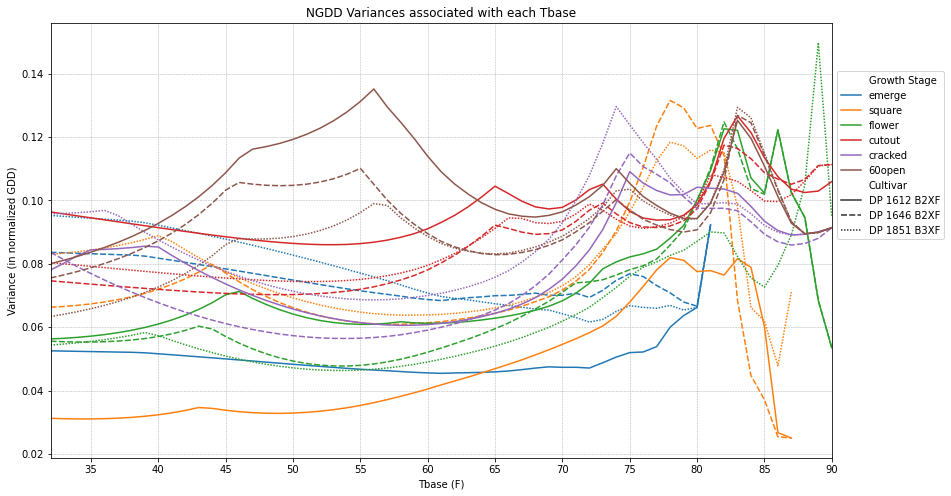

In [205]:
# Create a plot of all normalized GDD variances, for all clusters and growth stages, against Tbase
fig,ax = plt.subplots(1,figsize=(14,8))

sns.lineplot(x='tbase',y='var_normgdd',style='Cultivar',hue='Growth Stage',hue_order=list(stages_all),
                  data=gdd_normalized_tbases.rename(columns={'cultivar':'Cultivar','stage':'Growth Stage'}),ax=ax)
ax.legend(bbox_to_anchor=(0.65, 0, 0.5, 0.9))
ax.set_xlabel("Tbase (F)")
plt.xticks(np.arange(30, 91, 5))
plt.xlim([32,90])

ax.set_title("NGDD Variances associated with each Tbase")
ax.set_ylabel("Variance (in normalized GDD)")
plt.grid(linestyle='--',linewidth=0.5)

#plt.show();
plt.savefig('OutputFiles/Planting-to-Stage-All-Stages-Together.png')

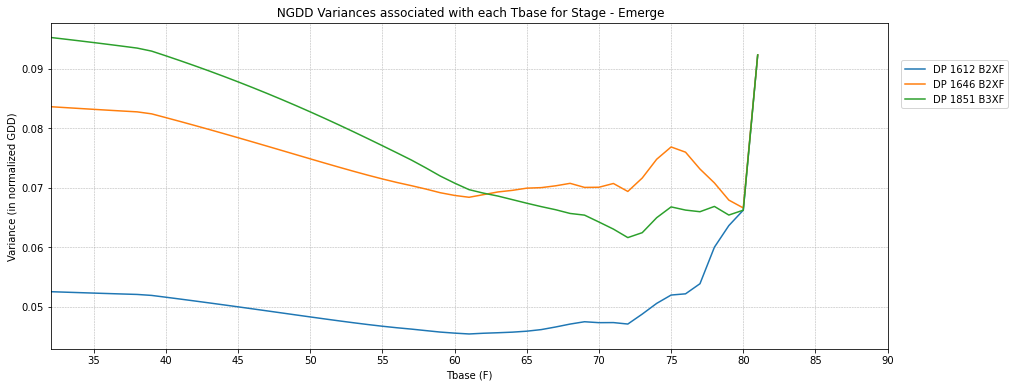

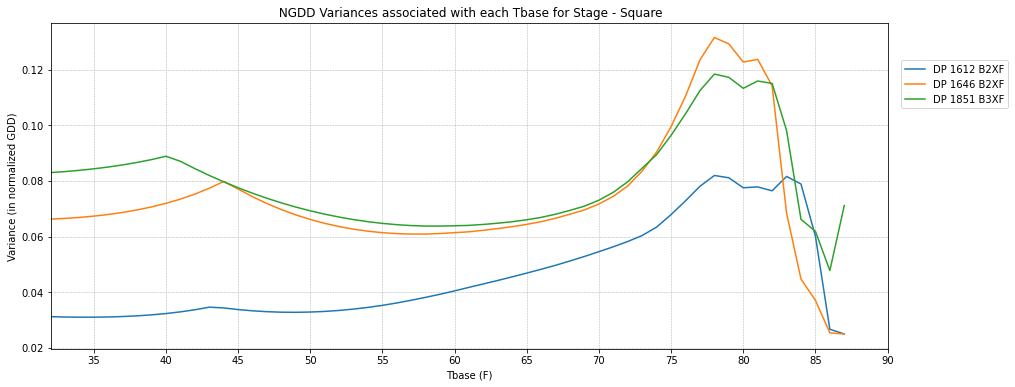

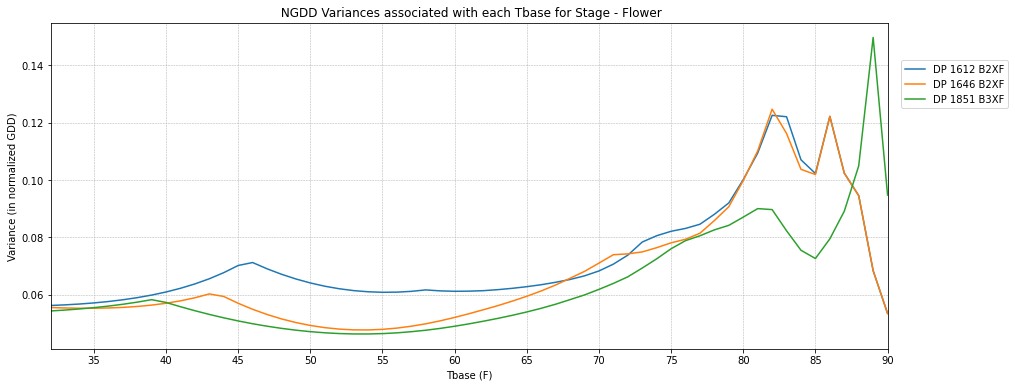

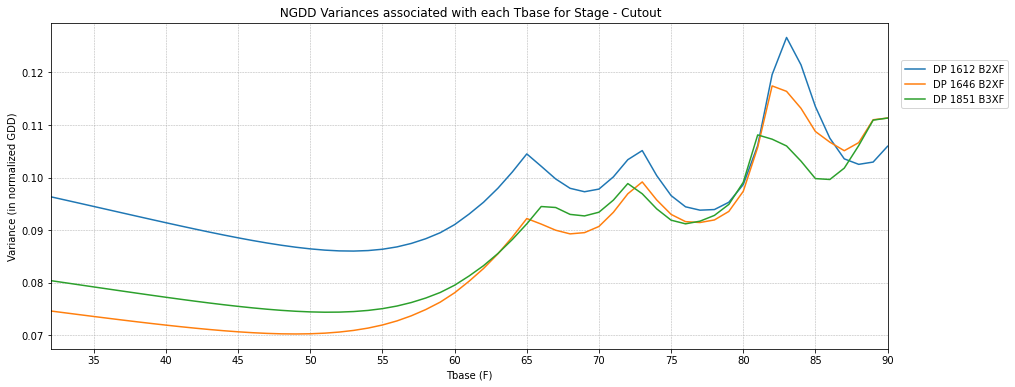

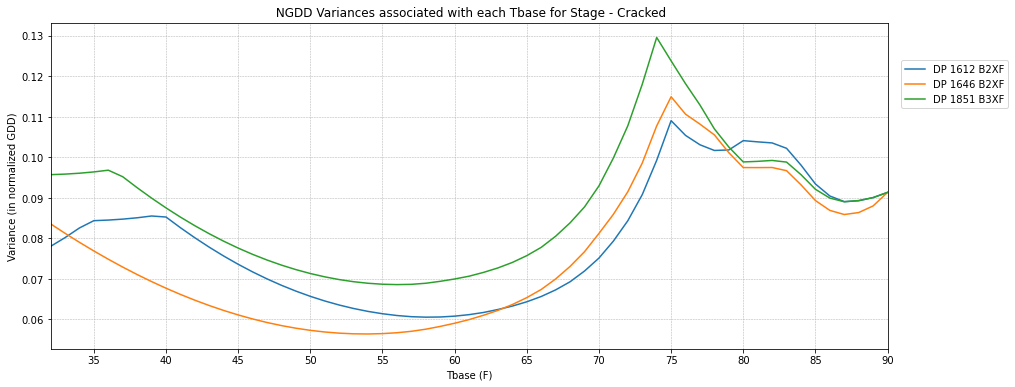

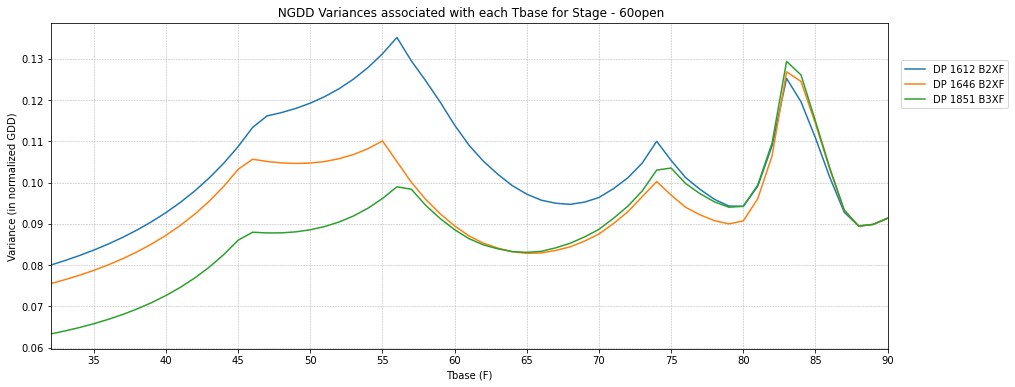

In [206]:
stage_tbase_opt = []

for s in range(len(stages_all)):

    fig,ax = plt.subplots(1,figsize=(15,6))

    sns.lineplot(x='tbase',y='var_normgdd',hue='cultivar',
                  data=gdd_normalized_tbases[gdd_normalized_tbases['stage']==stages_all[s]],ax=ax)

    ax.set_title(" NGDD Variances associated with each Tbase for Stage - " + stages_all[s].capitalize())
    ax.set_ylabel("Variance (in normalized GDD)")
    ax.legend(bbox_to_anchor=(0.65, 0, 0.5, 0.9))
    ax.set_xlabel("Tbase (F)")
    plt.xticks(np.arange(30, 91, 5))
    plt.xlim([32,90])

    plt.grid(linestyle='--',linewidth=0.5)
    #plt.show()
    plt.savefig('OutputFiles/planting-to-stage_'+stages_all[s]+'.png')

    
    
    # Print out the tbase with minimum variance (looking between 55 and 75)
    min_F = 55
    max_F = 75
    if(stages_all[s]=='square'):
        min_F = 42 
    if(stages_all[s]=='flower'):
        min_F = 45
    if(stages_all[s]=='cutout'):
        min_F = 66
        max_F = 72
    if(stages_all[s]=='cracked'):
        min_F = 40
    cultivars = gdd_normalized_tbases.cultivar.unique()
    for v in range(len(cultivars)):

        min_var_val = gdd_normalized_tbases[(gdd_normalized_tbases['stage']==stages_all[s]) & 
                              (gdd_normalized_tbases['tbase']>=min_F) &
                              (gdd_normalized_tbases['tbase']<=max_F) &
                              (gdd_normalized_tbases['cultivar']==cultivars[v])]['var_normgdd'].min()
        min_var_tbase = gdd_normalized_tbases[(gdd_normalized_tbases['stage']==stages_all[s]) & 
                              (gdd_normalized_tbases['tbase']>=min_F) &
                              (gdd_normalized_tbases['tbase']<=max_F) &
                              (gdd_normalized_tbases['var_normgdd']==min_var_val) &
                              (gdd_normalized_tbases['cultivar']==cultivars[v])]['tbase'].values[0]
        
        needed_gdd_tbase = gdd_avg_needed_by_stage[(gdd_avg_needed_by_stage['stage']==stages_all[s]) &
                                                   (gdd_avg_needed_by_stage['tbase']==min_var_tbase)
                                                  ]['cum_gdd'].values[0]
        
        stage_tbase_opt.append({'Cultivar':cultivars[v],'Stage':stages_all[s],'Tbase':min_var_tbase,
                               'GDD_Threshold':needed_gdd_tbase})

opt_tbase_plantToStage = pd.DataFrame(stage_tbase_opt)

In [207]:
# Format optimal base temp table for easier reading and prng
opt_tbase_plantToStage.reset_index()

# Create a numeric column for stages = called stage num
opt_tbase_plantToStage['stage_num'] = opt_tbase_plantToStage['Stage'].map(stage_dict)

# Sort by cultivar, stage
opt_tbase_plantToStage.sort_values(by=['Cultivar','stage_num'],inplace=True)

# Print
display(opt_tbase_plantToStage)

,Cultivar,Stage,Tbase,GDD_Threshold,stage_num
0,DP 1612 B2XF,emerge,61,93.91750,1
3,DP 1612 B2XF,square,49,1060.06000,2
6,DP 1612 B2XF,flower,55,1411.09500,3
9,DP 1612 B2XF,cutout,69,890.48125,4
12,DP 1612 B2XF,cracked,58,2404.33500,5
15,DP 1612 B2XF,60open,68,1479.48500,6
1,DP 1646 B2XF,emerge,61,93.91750,1
4,DP 1646 B2XF,square,57,743.69000,2
7,DP 1646 B2XF,flower,54,1472.82000,3
10,DP 1646 B2XF,cutout,68,970.88125,4


## Create a plot with the distribution of GDDs needed for each stage, based on training set
(do this for 60open only)

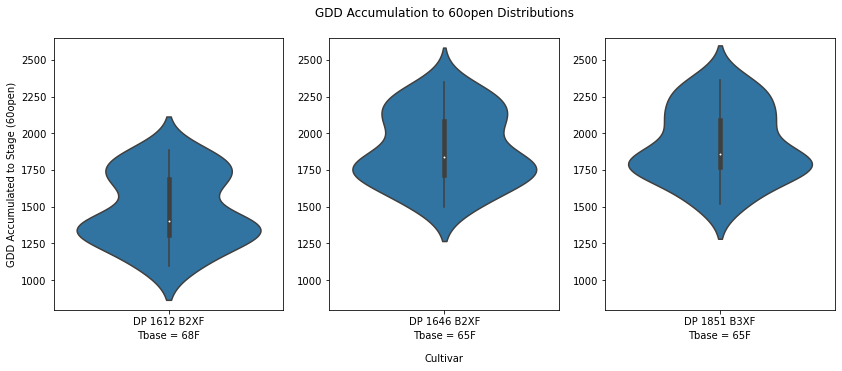

In [208]:
fig,ax = plt.subplots(1,3,figsize=(14,5))

for v in range(3):
    tbase_curr = opt_tbase_plantToStage[(opt_tbase_plantToStage['Cultivar']==cultivars[v]) &
                                (opt_tbase_plantToStage['Stage']=='60open')]['Tbase'].values[0]

    sns.violinplot(x='cultivar',y='cum_gdd',
        data=gdd_by_tbase[(gdd_by_tbase['cultivar']==cultivars[v]) & (gdd_by_tbase['stage']=='60open') &
                                (gdd_by_tbase['tbase']==tbase_curr)],
                  ax=ax[v])
    ax[v].set_ylim([800,2650])
    xlabel_str = 'Tbase = '+str(tbase_curr)+'F'
    ylabel_str = ''
    if v == 0:
        ylabel_str = 'GDD Accumulated to Stage (60open)'
    if v == 1:
        xlabel_str = xlabel_str+'\n\nCultivar'
    ax[v].set_xlabel(xlabel_str)
    ax[v].set_ylabel(ylabel_str)

ax[1].set_title('GDD Accumulation to 60open Distributions\n');


In [209]:
vald_df = getPredObs_DaysToStage(opt_tbase_plantToStage,growth_pd[growth_pd['test_train']==0].copy(),wxdf,'from_plant')

vald_df.groupby(['cultivar','stage_num'])['Obs-Pred'].describe()

count       mean        std   min    25%  50%    75%  \
cultivar     stage_num                                                         
DP 1612 B2XF 1           48.0  -1.979167   4.455404 -11.0  -4.00 -1.0   1.00   
             2           48.0  -0.270833   7.505288 -15.0  -3.00  1.0   3.25   
             3           48.0  -3.312500   8.916054 -24.0  -7.00 -2.5   4.00   
             4           48.0  -7.062500  12.706852 -32.0 -17.25 -3.5   4.00   
             5           48.0  -2.229167  10.310580 -21.0  -8.00 -2.5   3.25   
             6           28.0  11.464286  13.887063  -6.0  -1.25  9.0  21.25   
DP 1646 B2XF 1           48.0  -1.395833   4.565083 -11.0  -4.00  0.0   2.00   
             2           48.0   2.604167  11.333887 -20.0  -2.50  4.0  11.00   
             3           48.0   0.416667   9.332700 -21.0  -4.00  0.5   8.00   
             4           48.0  -4.416667  10.940523 -26.0 -11.50 -1.5   4.00   
             5           48.0   0.687500  10.396718 -16.0  -5.25 -2.0   6.25   
             6           36.0   3.055556  19.198132 -36.0  -5.00  1.5  18.50   
DP 1851 B3XF 1           48.0  -7.791667  15.620443 -47.0 -12.00 -1.0   3.00   
             2           48.0   3.104167  11.105375 -19.0  -2.50  5.0   9.25   
             3           48.0   1.520833   8.562634 -16.0  -2.25  2.0   8.00   
             4           48.0  -3.875000  11.534638 -25.0 -13.00 -2.5   6.00   
             5           48.0   2.458333  11.614295 -18.0  -5.00  1.5   7.50   
             6           36.0   4.500000  19.990712 -34.0  -4.25  3.5  23.25   

                         max  
cultivar     stage_num        
DP 1612 B2XF 1           4.0  
             2          17.0  
             3           9.0  
             4          11.0  
             5          18.0  
             6          36.0  
DP 1646 B2XF 1           6.0  
             2          22.0  
             3          14.0  
             4          14.0  
             5          28.0  
             6          32.0  
DP 1851 B3XF 1           9.0  
             2          23.0  
             3          15.0  
             4          16.0  
             5          30.0  
             6          35.0

## Repeating empirical method from above, but this time looking at just the between-stages Tbase and GDD requirements

In [210]:
# Set min and max tbases to test
tbase_min = 32
tbase_max = 90

In [211]:
wxdf_copy = wxdf.copy().reset_index()
for tbase in range(tbase_min,tbase_max+1):
    wxdf_copy['gdd_'+str(tbase)] = 0
    wxdf_copy.loc[wxdf_copy['tmean_F']>tbase,'gdd_'+str(tbase)] = wxdf_copy['tmean_F'] - tbase

In [212]:
train_data = growth_pd[(growth_pd['test_train']==1)].copy()
train_data.set_index(['loc_id','cultivar','plot'],inplace=True)

In [213]:
# Create an array with all the GDD column names
cum_gdd_cols = ['gdd_'+str(x)+'_cum' for x in range(tbase_min,tbase_max+1)]

In [214]:
arr_gdd_by_tbase = []
for i in set(train_data.index):
    copy_train = train_data.loc[i].copy()
    
    # Get start and end dates corresponding to this location's (loc_id-cultivar-plot) plant date and harvest (60open)
    plant_day = copy_train[copy_train['stage_num']==1]['day_of_year_stage'].values[0] - \
                copy_train[copy_train['stage_num']==1]['elapse_days'].values[0]

    # Iterate through each stage
    for s in range(1,7):
        
        # Get the day of year for the previous growth stage:
        prev_day_year = np.nan
        if s==1:
            prev_day_year = plant_day-1
        else:
            prev_arr = copy_train[copy_train['stage_num']==s-1]['day_of_year_stage'].values
            if len(prev_arr)>0:
                prev_day_year = prev_arr[0]

        # Get current stage day of year:
        stage_day_of_year = np.nan
        stage_day_arr = copy_train[copy_train['stage_num']==s]['day_of_year_stage'].values
        if len(stage_day_arr)>0:
            stage_day_of_year = stage_day_arr[0]

        # If we have both this stage's date AND the last stage's date, we can compute
        if (math.isnan(prev_day_year)==False) & (math.isnan(stage_day_of_year)==False):

            # Get weather data corresponding to just this location-plot 
            gdd_df = wxdf_copy[(wxdf_copy['loc_id']==list(i)[0]) & 
                                  (wxdf_copy['date']>prev_day_year) &
                                  (wxdf_copy['date']<=stage_day_of_year)].copy()

            # Accumulate gdd here
            gdd_sum_tbase = []
            for tbase in range(tbase_min,tbase_max+1):
                #gdd_df['gdd_'+str(tbase)+'_cum'] = gdd_df['gdd_'+str(tbase)].cumsum()
                gdd_sum_tbase.append(gdd_df['gdd_'+str(tbase)].sum())

            # Get the cumulative gdd correspnding to each growth stage
            #days_stages = copy_train['day_of_year_stage'].values 
            #stages = copy_train['growth stage'].values

            #cum_gdd_stages = np.array(gdd_df[gdd_df['date'].isin(days_stages)][cum_gdd_cols].values)
            #print(cum_gdd_stages.shape)
            for t in range(tbase_min,tbase_max+1):
                arr_gdd_by_tbase.append({'loc_id':list(i)[0],'plot':list(i)[2],'cultivar':list(i)[1],
                             'tbase':t,'stage':stages_all[s-1],'cum_gdd':gdd_sum_tbase[t-tbase_min]})

In [215]:
# Now compute normalized GDD for each stage
gdd_by_tbase = pd.DataFrame(arr_gdd_by_tbase)
gdd_by_tbase['max_ngdd_all'] = gdd_by_tbase.groupby(by=['cultivar','stage','tbase'])['cum_gdd'].transform('max')
gdd_by_tbase['min_ngdd_all'] = gdd_by_tbase.groupby(by=['cultivar','stage','tbase'])['cum_gdd'].transform('min')

gdd_by_tbase['norm_gdd'] = (gdd_by_tbase['cum_gdd'] - gdd_by_tbase['min_ngdd_all'])/ \
                           (gdd_by_tbase['max_ngdd_all'] - gdd_by_tbase['min_ngdd_all'])

In [216]:
# Create "vectors" of normalized GDD by each cultivar, stage, and Tbase
gdd_normalized_tbases = pd.DataFrame(gdd_by_tbase.groupby(['cultivar','stage','tbase']).norm_gdd.var().reset_index())
gdd_normalized_tbases.rename(columns={'norm_gdd':'var_normgdd'},inplace=True)

In [217]:
# Compute the average GDD accumulation by cultivar-stage-Tbase (will output the one that "matches" optimal Tbase)
gdd_avg_needed_by_stage = pd.DataFrame(gdd_by_tbase.groupby(['cultivar','stage','tbase']).\
                                       cum_gdd.mean().reset_index())

Text(0, 0, '')


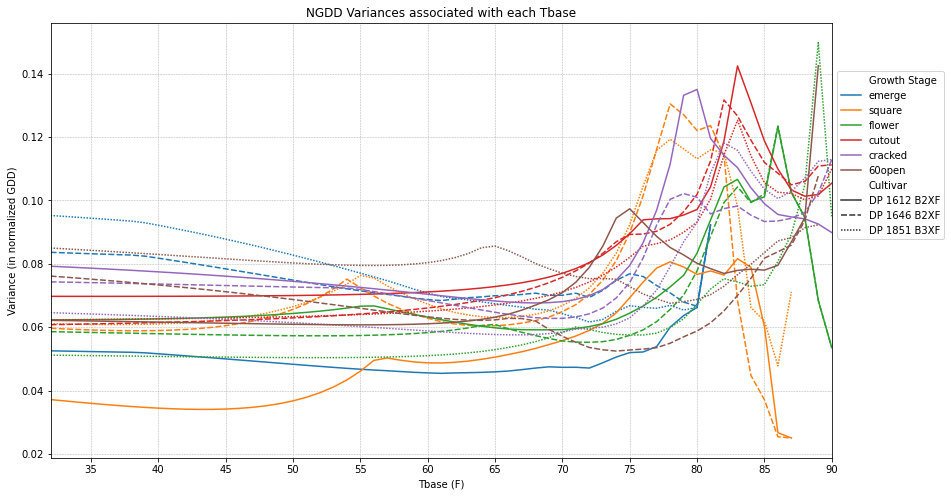

In [218]:
# Create a plot of all normalized GDD variances, for all clusters and growth stages, against Tbase
fig,ax = plt.subplots(1,figsize=(14,8))

sns.lineplot(x='tbase',y='var_normgdd',style='Cultivar',hue='Growth Stage',hue_order=list(stages_all),
                  data=gdd_normalized_tbases.rename(columns={'cultivar':'Cultivar','stage':'Growth Stage'}),ax=ax)
ax.legend(bbox_to_anchor=(0.65, 0, 0.5, 0.9))
ax.set_xlabel("Tbase (F)")
plt.xticks(np.arange(30, 91, 5))
plt.xlim([32,90])

ax.set_title("NGDD Variances associated with each Tbase")
ax.set_ylabel("Variance (in normalized GDD)")
plt.grid(linestyle='--',linewidth=0.5)

print(ax.get_legend().get_title());
#plt.show();
plt.savefig('OutputFiles/Stage-to-Stage-All-Stages-Together.png')

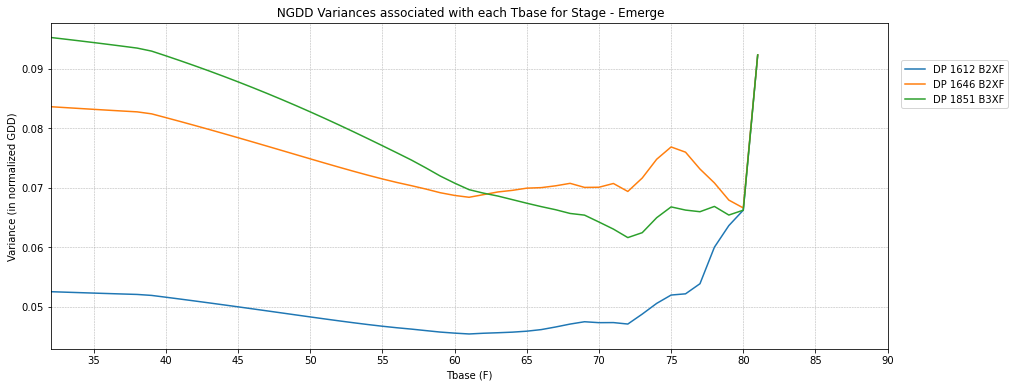

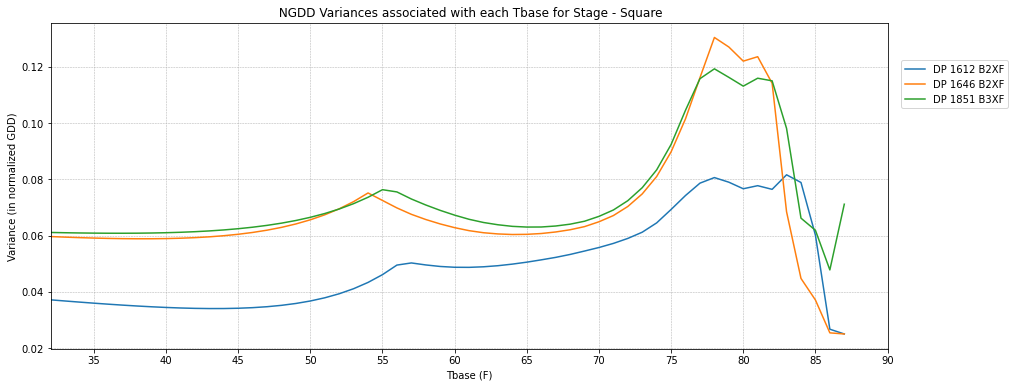

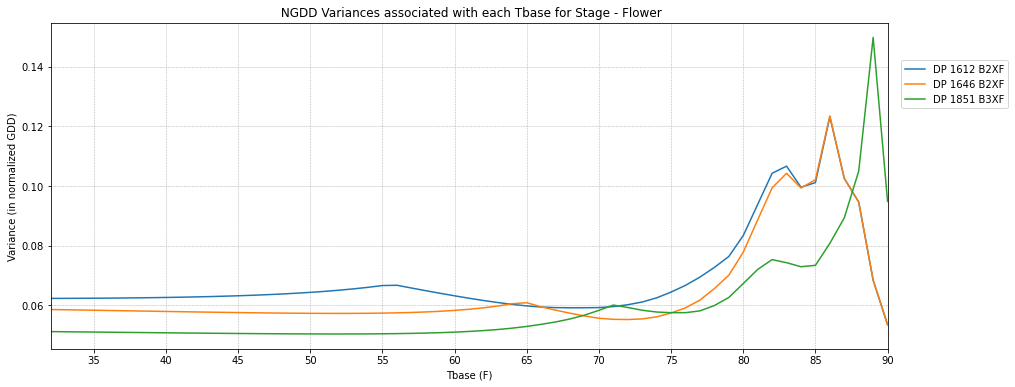

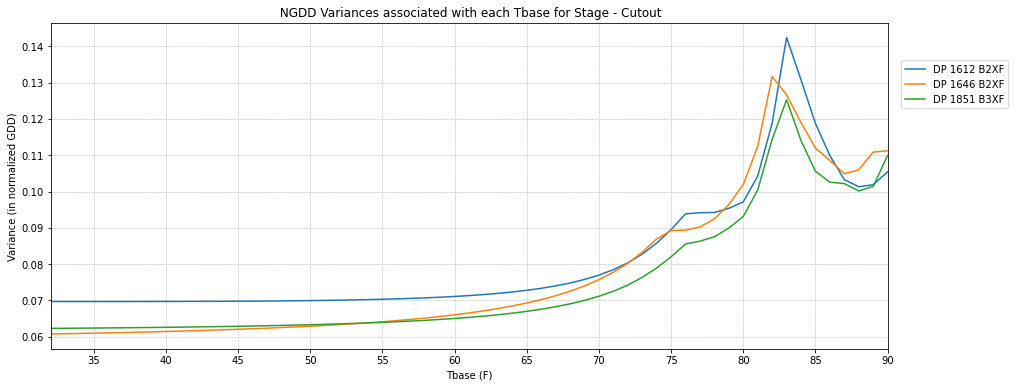

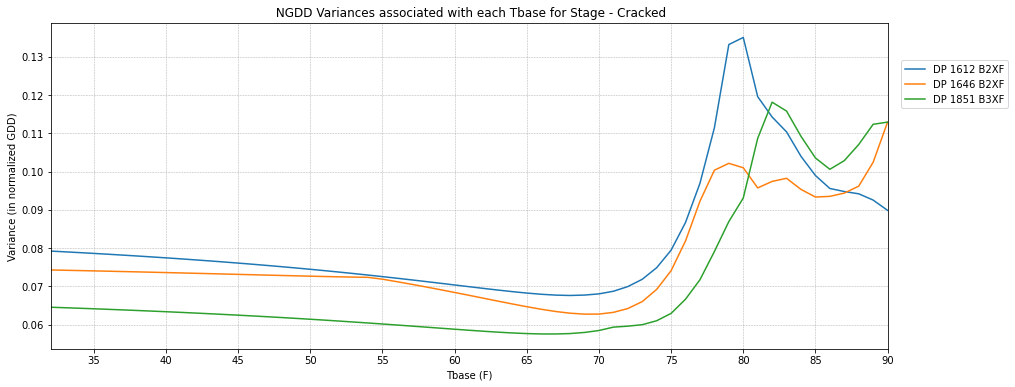

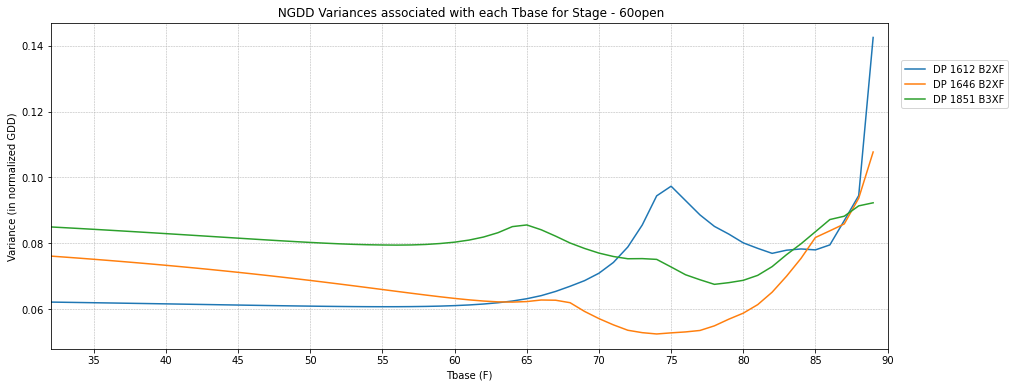

In [219]:
# Do same as above -- but this time, a separate plot for each growth stage
stage_tbase_opt = []

for s in range(len(stages_all)):

    fig,ax = plt.subplots(1,figsize=(15,6))

    sns.lineplot(x='tbase',y='var_normgdd',hue='cultivar',
                  data=gdd_normalized_tbases[gdd_normalized_tbases['stage']==stages_all[s]],ax=ax)

    ax.set_title(" NGDD Variances associated with each Tbase for Stage - " + stages_all[s].capitalize())
    ax.set_ylabel("Variance (in normalized GDD)")
    ax.legend(bbox_to_anchor=(0.65, 0, 0.5, 0.9))
    ax.set_xlabel("Tbase (F)")
    plt.xticks(np.arange(30, 91, 5))
    plt.xlim([32,90])

    plt.grid(linestyle='--',linewidth=0.5)
    plt.savefig('OutputFiles/stage-to-stage_'+stages_all[s]+'.png')
    
    
    # Print out the tbase with minimum variance (looking between 55 and 75)
    min_F = 55
    max_F = 75
    if(stages_all[s]=='square'):
        min_F = 56
    if(stages_all[s]=='flower'):
        min_F = 45
    if(stages_all[s]=='cutout'):
        min_F = 60
        max_F = 72
    if(stages_all[s]=='60open'):
        min_F = 45
        max_F = 68 
    cultivars = gdd_normalized_tbases.cultivar.unique()
    for v in range(len(cultivars)):

        min_var_val = gdd_normalized_tbases[(gdd_normalized_tbases['stage']==stages_all[s]) & 
                              (gdd_normalized_tbases['tbase']>=min_F) &
                              (gdd_normalized_tbases['tbase']<=max_F) &
                              (gdd_normalized_tbases['cultivar']==cultivars[v])]['var_normgdd'].min()
        min_var_tbase = gdd_normalized_tbases[(gdd_normalized_tbases['stage']==stages_all[s]) & 
                              (gdd_normalized_tbases['tbase']>=min_F) &
                              (gdd_normalized_tbases['tbase']<=max_F) &
                              (gdd_normalized_tbases['var_normgdd']==min_var_val) &
                              (gdd_normalized_tbases['cultivar']==cultivars[v])]['tbase'].values[0]
        
        needed_gdd_tbase = gdd_avg_needed_by_stage[(gdd_avg_needed_by_stage['stage']==stages_all[s]) &
                                                   (gdd_avg_needed_by_stage['tbase']==min_var_tbase)
                                                  ]['cum_gdd'].values[0]
        
        stage_tbase_opt.append({'Cultivar':cultivars[v],'Stage':stages_all[s],'Tbase':min_var_tbase,
                               'GDD_Threshold':needed_gdd_tbase})

opt_tbase_stageToStage = pd.DataFrame(stage_tbase_opt)

In [220]:
# Format optimal base temp table for easier reading and prng
opt_tbase_stageToStage.reset_index()

# Create a numeric column for stages = called stage num
opt_tbase_stageToStage['stage_num'] = opt_tbase_stageToStage['Stage'].map(stage_dict)

# Sort by cultivar, stage
opt_tbase_stageToStage.sort_values(by=['Cultivar','stage_num'],inplace=True)

# Print
display(opt_tbase_stageToStage)

,Cultivar,Stage,Tbase,GDD_Threshold,stage_num
0,DP 1612 B2XF,emerge,61,93.917500,1
3,DP 1612 B2XF,square,61,493.312500,2
6,DP 1612 B2XF,flower,68,300.427500,3
9,DP 1612 B2XF,cutout,60,537.950000,4
12,DP 1612 B2XF,cracked,68,340.659375,5
15,DP 1612 B2XF,60open,55,380.122500,6
1,DP 1646 B2XF,emerge,61,93.917500,1
4,DP 1646 B2XF,square,64,400.897500,2
7,DP 1646 B2XF,flower,72,213.437500,3
10,DP 1646 B2XF,cutout,60,537.950000,4


In [221]:
stageeach_vald_df = getPredObs_DaysToStage(
    opt_tbase_stageToStage,growth_pd[growth_pd['test_train']==0].copy(),wxdf,'each')

stageeach_vald_df.groupby(['cultivar','stage_num'])['Obs-Pred'].describe()

count      mean        std   min    25%  50%    75%  \
cultivar     stage_num                                                        
DP 1612 B2XF 1           48.0 -1.979167   4.455404 -11.0  -4.00 -1.0   1.00   
             2           48.0 -0.187500   9.479331 -21.0  -3.00  1.0   5.00   
             3           48.0 -4.729167   6.330405 -17.0  -8.00 -5.0  -2.00   
             4           48.0 -1.416667   5.719817 -11.0  -6.00 -3.5   3.00   
             5           48.0  3.062500   7.636436 -10.0  -1.00  2.0   6.25   
             6           48.0  1.270833   6.066088 -17.0  -2.25  0.0   5.00   
DP 1646 B2XF 1           48.0 -1.395833   4.565083 -11.0  -4.00  0.0   2.00   
             2           48.0  2.625000  12.429589 -23.0  -2.00  5.0  13.00   
             3           48.0 -5.750000   7.421934 -24.0  -8.25 -5.0  -2.00   
             4           48.0 -2.041667   6.424548 -11.0  -8.00 -3.0   1.50   
             5           48.0  2.750000   9.694262 -14.0  -4.00  2.5   7.25   
             6           45.0  1.622222   7.392530  -8.0  -4.00  0.0   8.00   
DP 1851 B3XF 1           48.0 -7.791667  15.620443 -47.0 -12.00 -1.0   3.00   
             2           48.0  2.916667  12.103865 -21.0  -1.50  6.0  11.00   
             3           48.0 -1.791667   4.346475  -9.0  -5.00 -2.0   0.00   
             4           48.0 -1.979167   6.599451 -11.0  -7.00 -3.0   1.25   
             5           48.0  4.312500  10.053381 -13.0  -1.25  3.5   8.25   
             6           46.0  1.543478   7.649856 -14.0  -4.00 -0.5   9.00   

                         max  
cultivar     stage_num        
DP 1612 B2XF 1           4.0  
             2          19.0  
             3          10.0  
             4          10.0  
             5          19.0  
             6          15.0  
DP 1646 B2XF 1           6.0  
             2          23.0  
             3           9.0  
             4          14.0  
             5          31.0  
             6          17.0  
DP 1851 B3XF 1           9.0  
             2          22.0  
             3          11.0  
             4          13.0  
             5          30.0  
             6          15.0

## Write emprical thresholds and predictions to excel file

In [222]:
with pd.ExcelWriter('OutputFiles/Emprical_Thresholds_Predictions.xlsx') as writer:  
    opt_tbase_stageToStage.round(2).to_excel(writer,sheet_name='Stage_Only_Thresholds')
    
    stageeach_vald_df.groupby(['cultivar','stage_num'])['Obs-Pred']\
        .describe().round(2).to_excel(writer,sheet_name='Stage_Only_Predictions')
    
    opt_tbase_plantToStage.round(2).to_excel(writer,sheet_name='Full_Season_Thresholds')
    
    vald_df.groupby(['cultivar','stage_num'])['Obs-Pred'].describe().round(2)\
         .to_excel(writer,sheet_name='Full_Season_Predictions')
    
